In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import func_plot as fp
import seaborn as sns
import nibabel as nib
from scipy.stats import norm
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

AttributeError: type object 'PointSet' has no attribute '__vtkname__'

AttributeError: type object 'PointSet' has no attribute '__vtkname__'

# Gradient 1 parcelwise PLS

In [ ]:
# Load aligned Gradient 1
grad_df = pd.read_csv('./g1_aligned_cog.csv')

# Select only patients (diagnosis 2 or 3)
patient_df = grad_df[grad_df['diagnosis'].isin([2, 3])].copy()

# Extract Gradient 1 parcel values
parcel_cols = [f'node_{i+1}' for i in range(400)]
X = patient_df[parcel_cols].values  # shape: (n_patients, 400)

# Behavioral/clinical measures
clinical_vars = ['SAPSDisorganization', 'Amotivation', 'DimEx',
                 'SAPSPositiveSymptoms', 'hamilton_21', 'Long_free_recall',
                 'Short_free_recall', 'Free_recall_correct', 'Digit_span_backward',
                 'Digit_span_forward', 'Digit_span_sequencing', 'Letter_number_sequencing',
                 'Matrix_Reasoning', 'Vocabulary', 'YMRS']
Y = patient_df[clinical_vars].values  # shape: (n_patients, 5)

# Remove patients with any NaNs in behavioral measures
valid = ~np.isnan(Y).any(axis=1)
X_valid = X[valid]
Y_valid = Y[valid]

print(f"X_valid shape: {X_valid.shape}, Y_valid shape: {Y_valid.shape}")

# Standardize across patients
X_std = StandardScaler().fit_transform(X_valid)
Y_std = StandardScaler().fit_transform(Y_valid)

# Fit PLS
pls = PLSRegression(n_components=1)
pls.fit(X_std, Y_std)

# Saliences (loadings)
X_saliences = pls.x_loadings_[:,0]  # parcel-wise loadings (400,)
Y_saliences = pls.y_loadings_[:,0]  # behavioral loadings (5,)

# Individual composite scores
X_scores = pls.x_scores_[:,0]  # patient-specific Gradient 1 LC1
Y_scores = pls.y_scores_[:,0]  # patient-specific behavioral LC1
from scipy.stats import pearsonr

# Correlation of each behavioral measure with LC1. These correlations are used to interpret which behaviors are most strongly represented in LC1.
behav_corrs = [pearsonr(Y_std[:,i], Y_scores)[0] for i in range(Y_std.shape[1])]
print("Behavioral correlations with LC1:")
for b, c in zip(clinical_vars, behav_corrs):
    print(f"{b}: {c:.3f}")

X_valid shape: (73, 400), Y_valid shape: (73, 15)
Behavioral correlations with LC1:
SAPSDisorganization: -0.427
Amotivation: -0.505
DimEx: -0.423
SAPSPositiveSymptoms: -0.700
hamilton_21: -0.209
Long_free_recall: 0.557
Short_free_recall: 0.615
Free_recall_correct: 0.619
Digit_span_backward: 0.578
Digit_span_forward: 0.543
Digit_span_sequencing: 0.642
Letter_number_sequencing: 0.575
Matrix_Reasoning: 0.610
Vocabulary: 0.574
YMRS: -0.194


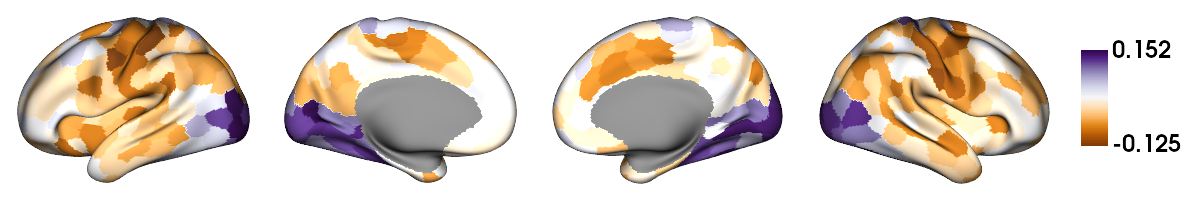

In [ ]:
brain_map = np.full_like(atlas, np.nan, dtype=float)
for j in range(len(X_saliences)):
    brain_map[atlas == j+1] = X_saliences[j]
brain_map[atlas == 0] = np.nan

fp.plot_surface(
    data=[brain_map],
    size=(1200, 200),
    cmap='PuOr',
    display=True,
    filename='./new_figures/Gradient1_LC1_map_cortex.png'
)


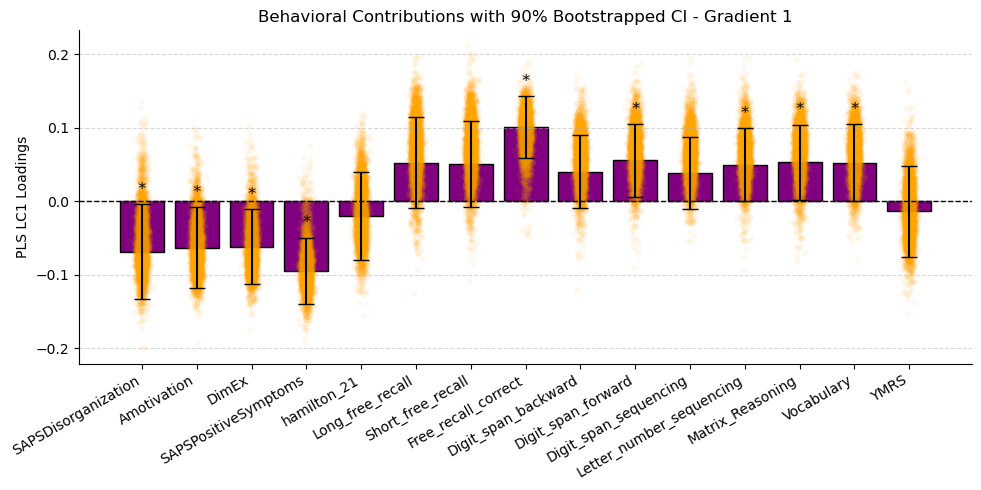

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import norm

# Bootstrapping behavioral loadings
n_boot = 5000
np.random.seed(4)
n_behav = Y_std.shape[1]
boot_y_saliences = np.zeros((n_boot, n_behav))

for b in range(n_boot):
    idx = np.random.choice(len(X_std), size=len(X_std), replace=True)
    Xb = X_std[idx]
    Yb = Y_std[idx]

    plsb = PLSRegression(n_components=1)
    plsb.fit(Xb, Yb)
    yb = plsb.y_loadings_[:, 0]

    if np.dot(yb, Y_saliences) < 0:
        yb *= -1
 
    boot_y_saliences[b, :] = yb

# Mean, SD, CI, p-values
y_mean = Y_saliences
y_sd = boot_y_saliences.std(axis=0)
lower_ci = y_mean - 1.645 * y_sd
upper_ci = y_mean + 1.645 * y_sd
p_values =  2 * (1 - norm.cdf(np.abs(y_mean / y_sd)))

# Simple linear colormap from min → max
cmap = plt.get_cmap('PiYG')
colors = [cmap((val - y_mean.min()) / (y_mean.max() - y_mean.min())) for val in y_mean]

# Plot
fig, ax = plt.subplots(figsize=(10,5))
bars = ax.bar(range(n_behav), y_mean,
              yerr=[y_mean - lower_ci, upper_ci - y_mean],
              capsize=6, color='purple', alpha=1, edgecolor='black')

# Overlay faint bootstrap points
for i in range(n_behav):
    y = boot_y_saliences[:, i]
    x = np.random.normal(i, 0.05, size=len(y))
    ax.scatter(x, y, color='orange', alpha=0.05, s=10)

# Horizontal line at zero
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Significance stars (CI not crossing zero)
for i in range(n_behav):
    if lower_ci[i] > 0 or upper_ci[i] < 0:
        ax.text(i, upper_ci[i] + 0.01, "*", ha='center', va='bottom', fontsize=12)

# Labels and aesthetics
ax.set_xticks(range(n_behav))
ax.set_xticklabels(clinical_vars, rotation=30, ha='right')
ax.set_ylabel('PLS LC1 Loadings')
ax.set_title('Behavioral Contributions with 90% Bootstrapped CI - Gradient 1')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
plt.savefig('./new_figures/g1_loadings.png', dpi=300)

plt.tight_layout()
plt.show()


Permutation test - observed singular values (top 5):
  LC1: singular_value=5.7982, perm_p=0.1099, fdr_p=0.5170, significant=False
  LC2: singular_value=3.3478, perm_p=0.9401, fdr_p=0.9401, significant=False
  LC3: singular_value=3.1800, perm_p=0.4136, fdr_p=0.5170, significant=False
  LC4: singular_value=2.7042, perm_p=0.4136, fdr_p=0.5170, significant=False
  LC5: singular_value=2.3929, perm_p=0.2827, fdr_p=0.5170, significant=False

Behavioral loadings bootstrap summary (90% CI, empirical p-values):
                    behavior  mean_loading      sd  ci90_lower  ci90_upper  \
0        SAPSDisorganization       -0.0685  0.0380     -0.1123      0.0105   
1                Amotivation       -0.0630  0.0330     -0.1092     -0.0024   
2                      DimEx       -0.0617  0.0310     -0.1048     -0.0053   
3       SAPSPositiveSymptoms       -0.0944  0.0271     -0.1300     -0.0454   
4                hamilton_21       -0.0200  0.0368     -0.0744      0.0471   
5           Long_free_rec

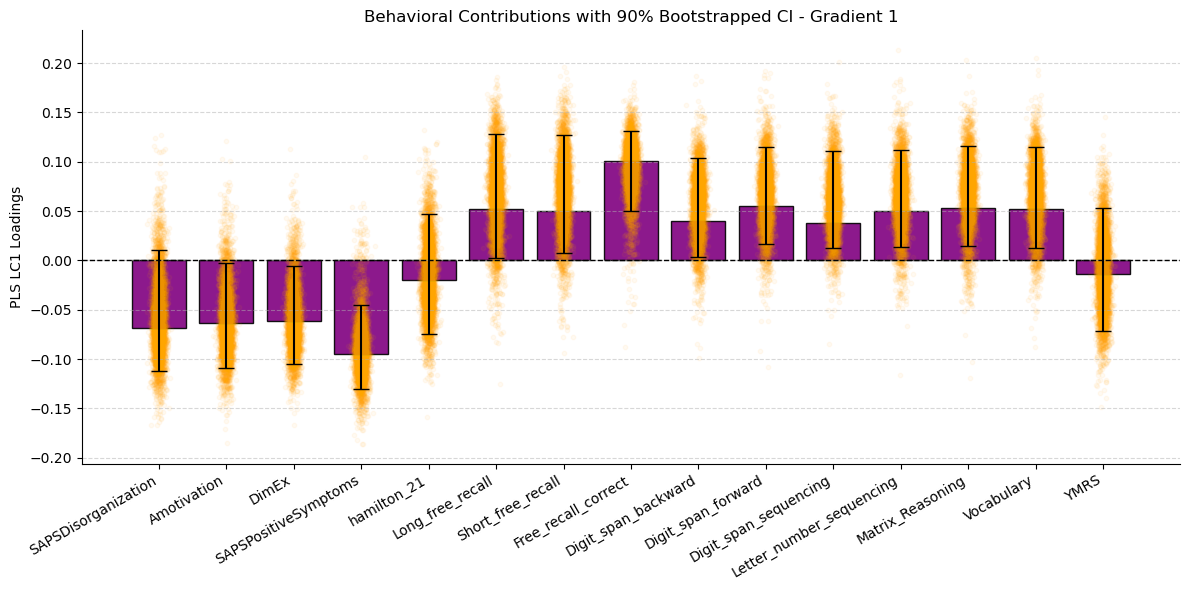

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from statsmodels.stats.multitest import multipletests
import pandas as pd

# ------------------------
# PARAMETERS
# ------------------------
n_perm = 1000      # number of permutations for LC significance
n_boot = 5000      # bootstrap samples
alpha = 0.05       # FDR alpha
topk = 5           # top K LCs for FDR on permutation test
rng = np.random.default_rng(4)

n, p = X_std.shape
q = Y_std.shape[1]

# ------------------------
# 1) Permutation test for LC significance
# ------------------------
C = (X_std.T @ Y_std) / n
U, s_obs, Vt = np.linalg.svd(C, full_matrices=False)   # observed singular values

perm_s = np.zeros((n_perm, s_obs.size))
for i in range(n_perm):
    perm_idx = rng.permutation(n)
    Yp = Y_std[perm_idx]
    Cp = (X_std.T @ Yp) / n
    s_perm = np.linalg.svd(Cp, full_matrices=False)[1]
    perm_s[i, :] = s_perm

pvals_perm = ((perm_s >= s_obs[None, :]).sum(axis=0) + 1) / (n_perm + 1)

topk = min(topk, s_obs.size)
reject, pvals_fdr, _, _ = multipletests(pvals_perm[:topk], alpha=alpha, method='fdr_bh')

print("Permutation test - observed singular values (top {}):".format(topk))
for k in range(topk):
    print(f"  LC{k+1}: singular_value={s_obs[k]:.4f}, perm_p={pvals_perm[k]:.4f}, "
          f"fdr_p={pvals_fdr[k]:.4f}, significant={reject[k]}")

# ------------------------
# 2) Bootstrap for behavioral loadings (percentile CI + empirical p)
# ------------------------
boot_y = np.zeros((n_boot, q))
for b in range(n_boot):
    idx = rng.integers(0, n, size=n)
    Xb = X_std[idx]
    Yb = Y_std[idx]
    plsb = PLSRegression(n_components=1)
    plsb.fit(Xb, Yb)
    yb = plsb.y_loadings_[:, 0].copy()
    # align sign to original
    if np.dot(yb, Y_saliences) < 0:
        yb *= -1
    boot_y[b, :] = yb

y_mean = Y_saliences
y_sd = boot_y.std(axis=0)

# Percentile 90% CI (5–95%)
lower_ci = np.percentile(boot_y, 5, axis=0)
upper_ci = np.percentile(boot_y, 95, axis=0)

# Empirical two-sided p-values
prop_ge0 = (boot_y >= 0).sum(axis=0) / n_boot
p_two_sided_emp = 2.0 * np.minimum(prop_ge0, 1.0 - prop_ge0)
p_two_sided_emp = np.minimum(p_two_sided_emp, 1.0)

# FDR correction
rej_behav, pvals_behav_fdr, _, _ = multipletests(p_two_sided_emp, alpha=alpha, method='fdr_bh')

# Summary table
df_beh = pd.DataFrame({
    'behavior': clinical_vars,
    'mean_loading': y_mean,
    'sd': y_sd,
    'ci90_lower': lower_ci,
    'ci90_upper': upper_ci,
    'p_two_sided_emp': p_two_sided_emp,
    'p_fdr_behav': pvals_behav_fdr,
    'signif_fdr': rej_behav
})
print("\nBehavioral loadings bootstrap summary (90% CI, empirical p-values):")
print(df_beh.round(4))

# ------------------------
# 3) Visualization (like your second code)
# ------------------------
fig, ax = plt.subplots(figsize=(12,6))

# Bar plot with error bars
bars = ax.bar(range(q), y_mean,
              yerr=[y_mean - lower_ci, upper_ci - y_mean],
              capsize=6, color='purple', alpha=0.9, edgecolor='black')

# Overlay faint bootstrap points
for i in range(q):
    y = boot_y[:, i]
    x = np.random.normal(i, 0.05, size=len(y))  # jitter
    ax.scatter(x, y, color='orange', alpha=0.05, s=10)

# Horizontal line at zero
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Significance stars for FDR-significant behaviors
for i in range(q):
    if rej_behav[i]:
        ax.text(i, upper_ci[i] + 0.02, "*", ha='center', va='bottom', fontsize=14, color='red')

# Labels
ax.set_xticks(range(q))
ax.set_xticklabels(clinical_vars, rotation=30, ha='right')
ax.set_ylabel('PLS LC1 Loadings')
ax.set_title('Behavioral Contributions with 90% Bootstrapped CI - Gradient 1')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('./new_figures/g1_loadings.png', dpi=300)
plt.show()



Behavioral correlations bootstrap summary:
                    variable       r  boot_sd  ci90_lower  ci90_upper   p_emp  \
0        SAPSDisorganization -0.4275   0.1009     -0.5777     -0.2444  0.0004   
1                Amotivation -0.5052   0.0881     -0.6430     -0.3577  0.0000   
2                      DimEx -0.4227   0.1002     -0.5763     -0.2469  0.0004   
3       SAPSPositiveSymptoms -0.7004   0.0513     -0.7791     -0.6117  0.0000   
4                hamilton_21 -0.2088   0.0975     -0.3673     -0.0438  0.0408   
5           Long_free_recall  0.5573   0.0813      0.4149      0.6837  0.0000   
6          Short_free_recall  0.6152   0.0814      0.4712      0.7374  0.0000   
7        Free_recall_correct  0.6189   0.0563      0.5203      0.7050  0.0000   
8        Digit_span_backward  0.5776   0.0731      0.4528      0.6895  0.0000   
9         Digit_span_forward  0.5429   0.0903      0.3821      0.6816  0.0000   
10     Digit_span_sequencing  0.6418   0.0599      0.5375      0.

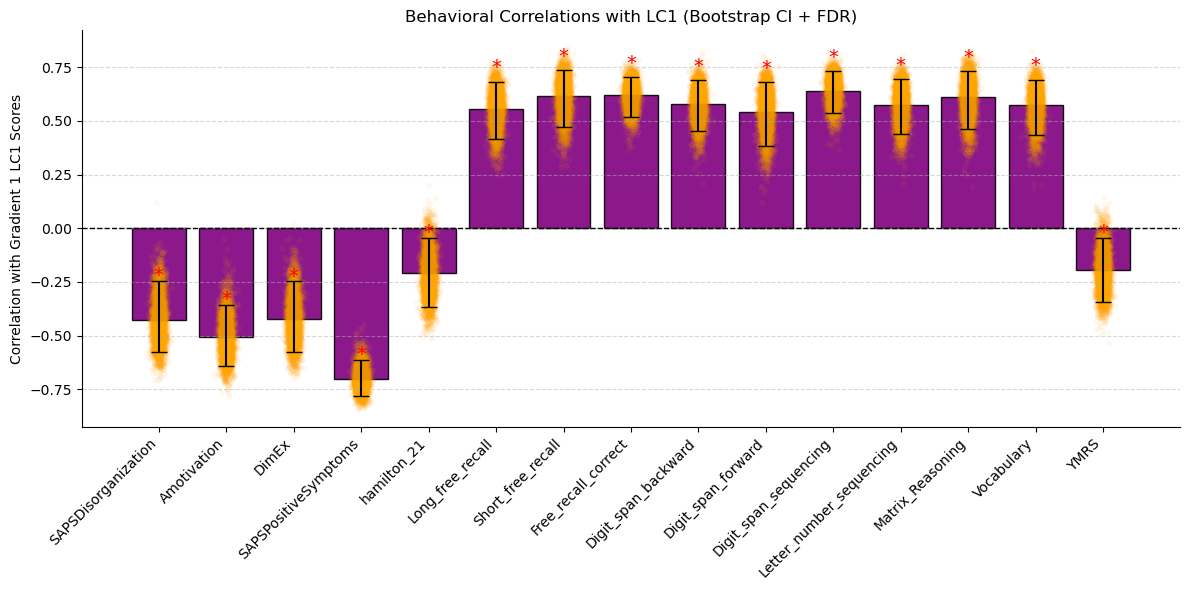

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.multitest import multipletests

# ------------------------
# PARAMETERS
# ------------------------
n_boot = 5000
alpha = 0.05
rng = np.random.default_rng(4)

# ------------------------
# 1. Original correlations (observed r)
# ------------------------
behav_corrs = np.array([
    np.corrcoef(Y_std[:, i], Y_scores)[0, 1] for i in range(Y_std.shape[1])
])

# ------------------------
# 2. Bootstrap correlations
# ------------------------
boot_corrs = np.zeros((n_boot, len(clinical_vars)))
for b in range(n_boot):
    idx = rng.integers(0, len(Y_std), size=len(Y_std))
    Yb = Y_std[idx, :]
    scores_b = Y_scores[idx]
    boot_corrs[b, :] = [np.corrcoef(Yb[:, i], scores_b)[0, 1] for i in range(Y_std.shape[1])]

# ------------------------
# 3. Statistics from bootstrap
# ------------------------
boot_sd = boot_corrs.std(axis=0)

# Percentile CI (90% or 95%, choose depending on paper convention)
lower_ci = np.percentile(boot_corrs, 5, axis=0)
upper_ci = np.percentile(boot_corrs, 95, axis=0)

# Empirical two-sided p-values (sign test)
prop_ge0 = (boot_corrs >= 0).sum(axis=0) / n_boot
p_two_sided_emp = 2.0 * np.minimum(prop_ge0, 1.0 - prop_ge0)
p_two_sided_emp = np.minimum(p_two_sided_emp, 1.0)  # cap at 1

# ------------------------
# 4. FDR correction
# ------------------------
reject, p_fdr, _, _ = multipletests(p_two_sided_emp, alpha=alpha, method='fdr_bh')

# ------------------------
# 5. Results table
# ------------------------
df_results = pd.DataFrame({
    'variable': clinical_vars,
    'r': behav_corrs,
    'boot_sd': boot_sd,
    'ci90_lower': lower_ci,
    'ci90_upper': upper_ci,
    'p_emp': p_two_sided_emp,
    'p_fdr': p_fdr,
    'significant': reject
})
print("\nBehavioral correlations bootstrap summary:")
print(df_results.round(4))

# ------------------------
# 6. Visualization
# ------------------------
fig, ax = plt.subplots(figsize=(12,6))

# Bar plot with error bars
bars = ax.bar(range(len(clinical_vars)), behav_corrs,
              yerr=[behav_corrs - lower_ci, upper_ci - behav_corrs],
              capsize=6, color='purple', alpha=0.9, edgecolor='black')

# Overlay faint bootstrap points
for i in range(len(clinical_vars)):
    y = boot_corrs[:, i]
    x = np.random.normal(i, 0.05, size=len(y))  # jitter
    ax.scatter(x, y, color='orange', alpha=0.05, s=10)

# Horizontal line at zero
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Significance stars for FDR-significant
for i, sig in enumerate(reject):
    if sig:
        ax.text(i, upper_ci[i] + 0.02 * np.sign(behav_corrs[i]),
                "*", ha='center', va='bottom', fontsize=14, color='red')

# Labels
ax.set_xticks(range(len(clinical_vars)))
ax.set_xticklabels(clinical_vars, rotation=45, ha='right')
ax.set_ylabel('Correlation with Gradient 1 LC1 Scores')
ax.set_title('Behavioral Correlations with LC1 (Bootstrap CI + FDR)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('./new_figures/g1_behavioral_corrs.png', dpi=300)
plt.show()


In [ ]:
from scipy.stats import ttest_ind

# Example: diagnosis groups (2 vs 3)
group1_idx = patient_df['diagnosis'] == 2
group2_idx = patient_df['diagnosis'] == 3

for lc in range(3):  # LC1, LC2, LC3
    # RSFC composite scores
    t_stat, p_val = ttest_ind(X_scores[group1_idx], X_scores[group2_idx])
    print(f"LC{lc+1} Gradient 1 t-test (diagnosis 2 vs 3): t={t_stat:.3f}, p={p_val:.4f}")

    # Behavioral composite scores
    t_stat, p_val = ttest_ind(Y_scores[group1_idx], Y_scores[group2_idx])
    print(f"LC{lc+1} behavior t-test (diagnosis 2 vs 3): t={t_stat:.3f}, p={p_val:.4f}")


IndexError: boolean index did not match indexed array along axis 0; size of axis is 73 but size of corresponding boolean axis is 77

c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


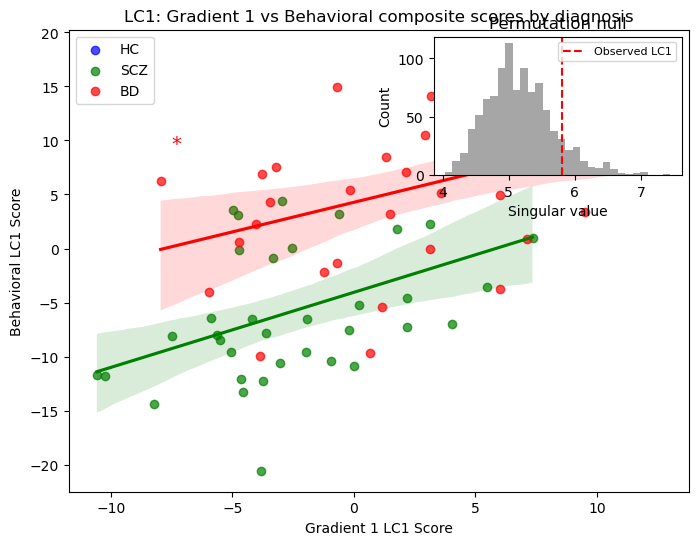

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ---------- Prepare LC1 scores ----------
X_scores_lc1 = pls.x_scores_[:,0]
Y_scores_lc1 = pls.y_scores_[:,0]

# Apply valid mask
valid_idx = valid  # same mask you used earlier
df_plot = patient_df[valid_idx].copy()
df_plot['Gradient1_LC1'] = X_scores_lc1
df_plot['Behavior_LC1'] = Y_scores_lc1

# ---------- Diagnostic groups ----------
diagnosis_map = {1:'HC', 2:'SCZ', 3:'BD'}
colors = {'HC':'blue', 'SCZ':'green', 'BD':'red'}

# ---------- Compute pairwise t-tests for FDR ----------
groups = list(diagnosis_map.keys())
pvals_rsfc = []
pvals_beh = []

# All pairwise comparisons
pairs = [(1,2),(1,3),(2,3)]
for g1,g2 in pairs:
    # RSFC
    idx1 = df_plot['diagnosis']==g1
    idx2 = df_plot['diagnosis']==g2
    t_stat, p_val = ttest_ind(df_plot.loc[idx1,'Gradient1_LC1'], df_plot.loc[idx2,'Gradient1_LC1'])
    pvals_rsfc.append(p_val)
    # Behavior
    t_stat, p_val = ttest_ind(df_plot.loc[idx1,'Behavior_LC1'], df_plot.loc[idx2,'Behavior_LC1'])
    pvals_beh.append(p_val)

# FDR correction
rej_rsfc, pvals_rsfc_fdr, _, _ = multipletests(pvals_rsfc, alpha=0.05, method='fdr_bh')
rej_beh, pvals_beh_fdr, _, _ = multipletests(pvals_beh, alpha=0.05, method='fdr_bh')

# ---------- Plot ----------
plt.figure(figsize=(8,6))

# Scatter + regression line per group
for diag_code, diag_name in diagnosis_map.items():
    grp = df_plot['diagnosis']==diag_code
    plt.scatter(df_plot.loc[grp,'Gradient1_LC1'], df_plot.loc[grp,'Behavior_LC1'],
                label=diag_name, alpha=0.7, color=colors[diag_name])

    # Regression line
    sns.regplot(x=df_plot.loc[grp,'Gradient1_LC1'],
                y=df_plot.loc[grp,'Behavior_LC1'],
                scatter=False, color=colors[diag_name])

plt.xlabel('Gradient 1 LC1 Score')
plt.ylabel('Behavioral LC1 Score')
plt.title('LC1: Gradient 1 vs Behavioral composite scores by diagnosis')
plt.legend()

# ---------- Inset: permutation null ----------
axins = inset_axes(plt.gca(), width="40%", height="30%", loc='upper right')
axins.hist(perm_s[:,0], bins=30, color='gray', alpha=0.7)
axins.axvline(s_obs[0], color='red', linestyle='--', label='Observed LC1')
axins.set_title('Permutation null')
axins.set_xlabel('Singular value')
axins.set_ylabel('Count')
axins.legend(fontsize=8)

# ---------- Add significance stars for group differences ----------
# Example: just above the scatter points
y_max = df_plot['Behavior_LC1'].max()
star_offsets = [0.1,0.15,0.2]  # vertical offsets for each pair
for i,(g1,g2) in enumerate(pairs):
    if rej_beh[i]:
        x1 = df_plot.loc[df_plot['diagnosis']==g1,'Gradient1_LC1'].mean()
        x2 = df_plot.loc[df_plot['diagnosis']==g2,'Gradient1_LC1'].mean()
        plt.text((x1+x2)/2, y_max + star_offsets[i], '*', ha='center', va='bottom', fontsize=14, color='red')

plt.show()


LC1 Gradient1 t-test (diagnosis 2 vs 3): t=-4.435, p=0.0000
LC1 behavior t-test (diagnosis 2 vs 3): t=-7.140, p=0.0000
LC2 Gradient1 t-test (diagnosis 2 vs 3): t=-4.435, p=0.0000
LC2 behavior t-test (diagnosis 2 vs 3): t=-7.140, p=0.0000
LC3 Gradient1 t-test (diagnosis 2 vs 3): t=-4.435, p=0.0000
LC3 behavior t-test (diagnosis 2 vs 3): t=-7.140, p=0.0000


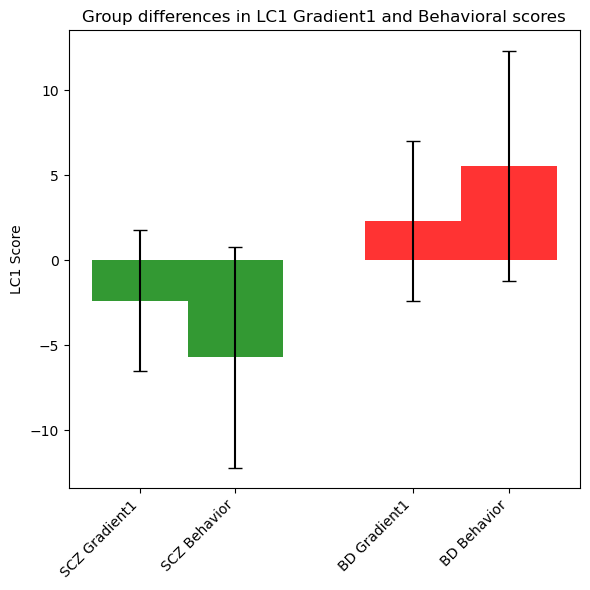

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Boolean mask for diagnosis groups, but only on valid subjects
group1_idx = (patient_df['diagnosis'] == 2).values[valid]
group2_idx = (patient_df['diagnosis'] == 3).values[valid]

for lc in range(3):  # LC1, LC2, LC3
    # RSFC composite scores
    t_stat, p_val = ttest_ind(X_scores[group1_idx], X_scores[group2_idx])
    print(f"LC{lc+1} Gradient1 t-test (diagnosis 2 vs 3): t={t_stat:.3f}, p={p_val:.4f}")

    # Behavioral composite scores
    t_stat, p_val = ttest_ind(Y_scores[group1_idx], Y_scores[group2_idx])
    print(f"LC{lc+1} behavior t-test (diagnosis 2 vs 3): t={t_stat:.3f}, p={p_val:.4f}")


# ---------- LC1 scores ----------
X_scores_lc1 = pls.x_scores_[:,0]
Y_scores_lc1 = pls.y_scores_[:,0]

# Keep only valid subjects
df_plot = patient_df[valid].copy()
df_plot['Gradient1_LC1'] = X_scores_lc1
df_plot['Behavior_LC1'] = Y_scores_lc1

# ---------- Diagnostic groups: only SCZ and BD ----------
diagnosis_map = {2:'SCZ', 3:'BD'}
groups = list(diagnosis_map.values())
colors = {'SCZ':'green', 'BD':'red'}

# ---------- Compute means and SDs ----------
scores_dict = {'Gradient1': df_plot['Gradient1_LC1'].values,
               'Behavior': df_plot['Behavior_LC1'].values}
summary_df = pd.DataFrame(columns=['Group','Type','Mean','SD'])

for typ in ['Gradient1','Behavior']:
    for grp_code, grp_name in diagnosis_map.items():
        idx = df_plot['diagnosis'] == grp_code
        summary_df = pd.concat([summary_df, pd.DataFrame({
            'Group':[grp_name],
            'Type':[typ],
            'Mean':[scores_dict[typ][idx].mean()],
            'SD':[scores_dict[typ][idx].std()]
        })])

# ---------- Pairwise t-tests ----------
pairs = [('SCZ','BD')]
pvals = {'Gradient1':[], 'Behavior':[]}

for typ in ['Gradient1','Behavior']:
    for g1, g2 in pairs:
        g1_code = [k for k,v in diagnosis_map.items() if v==g1][0]
        g2_code = [k for k,v in diagnosis_map.items() if v==g2][0]
        idx1 = df_plot['diagnosis']==g1_code
        idx2 = df_plot['diagnosis']==g2_code
        if idx1.sum() > 1 and idx2.sum() > 1:
            t_stat, p_val = ttest_ind(scores_dict[typ][idx1], scores_dict[typ][idx2])
            pvals[typ].append(p_val)
        else:
            pvals[typ].append(np.nan)

# FDR correction
rej_rsfc, pvals_rsfc_fdr, _, _ = multipletests(pvals['Gradient1'], alpha=0.05, method='fdr_bh')
rej_beh, pvals_beh_fdr, _, _ = multipletests(pvals['Behavior'], alpha=0.05, method='fdr_bh')

# ---------- Plot grouped bar ----------
fig, ax = plt.subplots(figsize=(6,6))
width = 0.35
x = np.arange(len(groups))  # one tick per group

# Plot bars side by side for Gradient1 and Behavior
bar_positions = []
for i, grp_name in enumerate(groups):
    for j, typ in enumerate(['Gradient1','Behavior']):
        pos = x[i] + j*width
        val = summary_df[(summary_df['Group']==grp_name) & (summary_df['Type']==typ)]['Mean'].values[0]
        err = summary_df[(summary_df['Group']==grp_name) & (summary_df['Type']==typ)]['SD'].values[0]
        color = colors[grp_name]
        ax.bar(pos, val, width, yerr=err, capsize=5, alpha=0.8, color=color)
        bar_positions.append(pos)

# X-axis ticks: one per bar
ax.set_xticks(bar_positions)
ax.set_xticklabels(['SCZ Gradient1','SCZ Behavior','BD Gradient1','BD Behavior'], rotation=45, ha='right')

ax.set_ylabel('LC1 Score')
ax.set_title('Group differences in LC1 Gradient1 and Behavioral scores')

plt.tight_layout()
plt.show()


In [23]:
# Only keep groups present in valid subjects
groups_present = df_plot['diagnosis'].unique()
diagnosis_map_valid = {code:name for code,name in diagnosis_map.items() if code in groups_present}
print(diagnosis_map_valid)


{2: 'SCZ', 3: 'BD'}


# Gradient 2 parcelwise PLS

In [ ]:
# Load aligned Gradient 2
grad2_df = pd.read_csv('./g2_aligned_cog.csv')

# Select only patients (diagnosis 2 or 3)
patient2_df = grad2_df[grad2_df['diagnosis'].isin([2, 3])].copy()

# Extract Gradient 2 parcel values
parcel_cols = [f'node_{i+1}' for i in range(400)]
X2 = patient2_df[parcel_cols].values

# Behavioral measures
# Behavioral/clinical measures
clinical_vars2 = ['SAPSDisorganization', 'Amotivation', 'DimEx',
                 'SAPSPositiveSymptoms', 'hamilton_21', 'Long_free_recall',
                 'Short_free_recall', 'Free_recall_correct', 'Digit_span_backward',
                 'Digit_span_forward', 'Digit_span_sequencing', 'Letter_number_sequencing',
                 'Matrix_Reasoning', 'Vocabulary', 'YMRS']
Y2 = patient2_df[clinical_vars2].values

# Remove patients with NaNs
valid2 = ~np.isnan(Y2).any(axis=1)
X2_valid = X2[valid2]
Y2_valid = Y2[valid2]

print(f"X2_valid shape: {X2_valid.shape}, Y2_valid shape: {Y2_valid.shape}")

# Standardize
X2_std = StandardScaler().fit_transform(X2_valid)
Y2_std = StandardScaler().fit_transform(Y2_valid)

# Fit PLS
pls2 = PLSRegression(n_components=1)
pls2.fit(X2_std, Y2_std)

# Saliences (loadings)
X2_saliences = pls2.x_loadings_[:,0]
Y2_saliences = pls2.y_loadings_[:,0]

# Individual composite scores
X2_scores = pls2.x_scores_[:,0]
Y2_scores = pls2.y_scores_[:,0]

# Behavioral correlations with LC1
behav_corrs2 = [pearsonr(Y2_std[:,i], Y2_scores)[0] for i in range(Y2_std.shape[1])]
print("Behavioral correlations with Gradient 2 LC1:")
for b, c in zip(clinical_vars2, behav_corrs2):
    print(f"{b}: {c:.3f}")


X2_valid shape: (73, 400), Y2_valid shape: (73, 15)
Behavioral correlations with Gradient 2 LC1:
SAPSDisorganization: -0.384
Amotivation: -0.484
DimEx: -0.403
SAPSPositiveSymptoms: -0.682
hamilton_21: -0.201
Long_free_recall: 0.595
Short_free_recall: 0.655
Free_recall_correct: 0.581
Digit_span_backward: 0.596
Digit_span_forward: 0.559
Digit_span_sequencing: 0.675
Letter_number_sequencing: 0.603
Matrix_Reasoning: 0.618
Vocabulary: 0.596
YMRS: -0.173


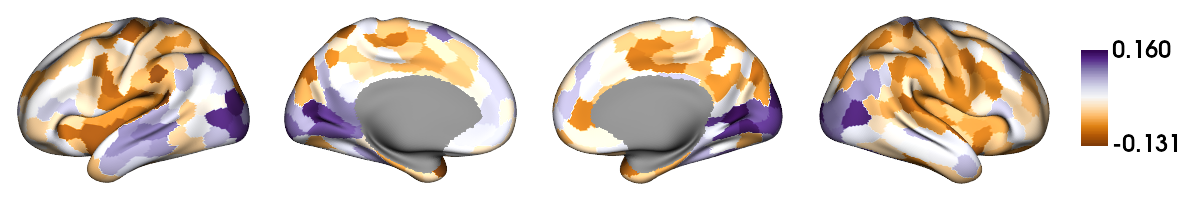

In [ ]:
# Create brain map
brain_map2 = np.full_like(atlas, np.nan, dtype=float)
for j in range(len(X2_saliences)):
    brain_map2[atlas == j+1] = X2_saliences[j]
brain_map2[atlas == 0] = np.nan

fp.plot_surface(
    data=[brain_map2],
    size=(1200, 200),
    cmap='PuOr',
    display=True,
    filename='./new_figures/Gradient2_LC1_map.png'
)


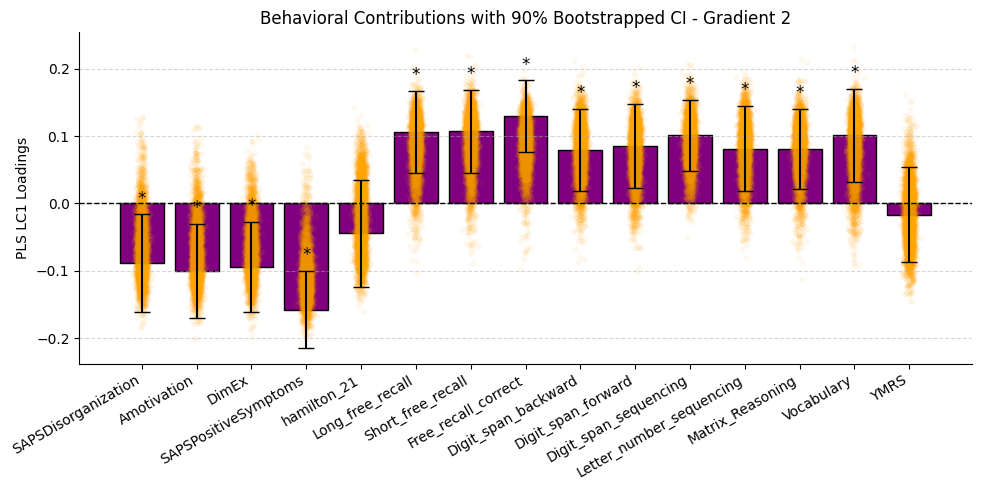

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import norm

# Bootstrapping behavioral loadings
n_boot = 5000
np.random.seed(42)
n_behav2 = Y2_std.shape[1]
boot_y2_saliences = np.zeros((n_boot, n_behav2))

for b in range(n_boot):
    idx = np.random.choice(len(X2_std), size=len(X2_std), replace=True)
    Xb = X2_std[idx]
    Yb = Y2_std[idx]

    plsb = PLSRegression(n_components=1)
    plsb.fit(Xb, Yb)
    yb = plsb.y_loadings_[:, 0]

    if np.dot(yb, Y2_saliences) < 0:
        yb *= -1

    boot_y2_saliences[b, :] = yb

# Mean, SD, CI, p-values
y_mean = Y2_saliences
y_sd = boot_y2_saliences.std(axis=0)
lower_ci = y_mean - 1.645 * y_sd
upper_ci = y_mean + 1.645 * y_sd
p_values = 2 * (1 - norm.cdf(np.abs(y_mean / y_sd)))

# Simple linear colormap from min → max
cmap = plt.get_cmap('PiYG')
colors = [cmap((val - y_mean.min()) / (y_mean.max() - y_mean.min())) for val in y_mean]

# Plot
fig, ax = plt.subplots(figsize=(10,5))
bars = ax.bar(range(n_behav2), y_mean,
              yerr=[y_mean - lower_ci, upper_ci - y_mean],
              capsize=6, color='purple', alpha=1, edgecolor='black')

# Overlay faint bootstrap points
for i in range(n_behav2):
    y = boot_y2_saliences[:, i]
    x = np.random.normal(i, 0.05, size=len(y))
    ax.scatter(x, y, color='orange', alpha=0.05, s=10)

# Horizontal line at zero
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Significance stars (CI not crossing zero)
for i in range(n_behav2):
    if lower_ci[i] > 0 or upper_ci[i] < 0:
        ax.text(i, upper_ci[i] + 0.01, "*", ha='center', va='bottom', fontsize=12)

# Labels and aesthetics
ax.set_xticks(range(n_behav2))
ax.set_xticklabels(clinical_vars2, rotation=30, ha='right')
ax.set_ylabel('PLS LC1 Loadings')
ax.set_title('Behavioral Contributions with 90% Bootstrapped CI - Gradient 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
plt.savefig('./new_figures/g2_loadings.png', dpi=300)
plt.tight_layout()
plt.show()


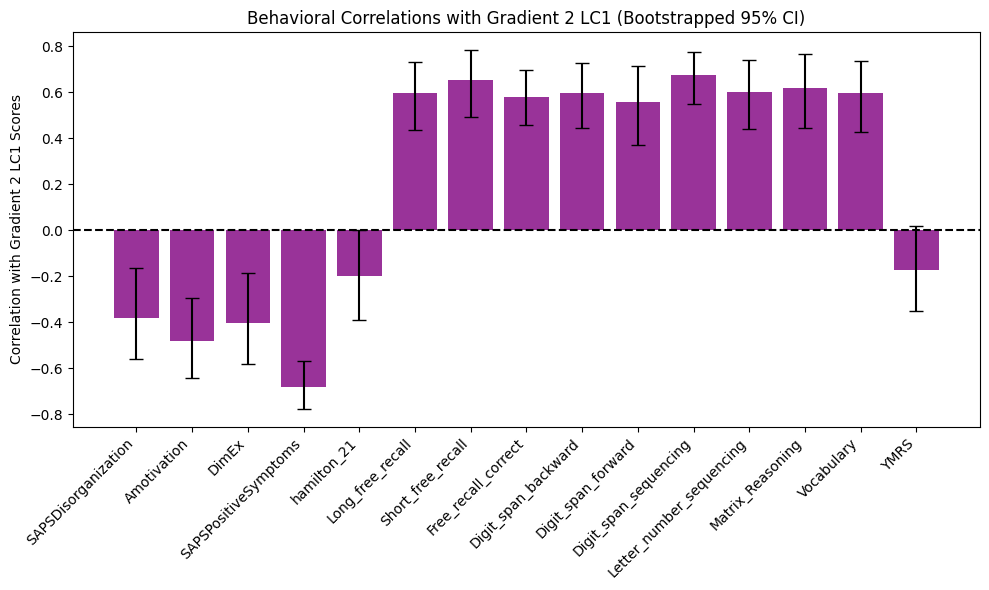

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Original correlations
behav_corrs2 = np.array([pearsonr(Y2_std[:, i], Y2_scores)[0] for i in range(Y2_std.shape[1])])

# Bootstrap correlations
boot_corrs2 = np.zeros((n_boot, len(clinical_vars2)))
for b in range(n_boot):
    idx = np.random.choice(len(Y2_std), size=len(Y2_std), replace=True)
    Yb = Y2_std[idx, :]
    scores_b = Y2_scores[idx]
    boot_corrs2[b, :] = [pearsonr(Yb[:, i], scores_b)[0] for i in range(Y2_std.shape[1])]

# Compute 95% confidence intervals
lower_ci = np.percentile(boot_corrs2, 2.5, axis=0)
upper_ci = np.percentile(boot_corrs2, 97.5, axis=0)

# Error bars = distance from mean to CI
yerr_lower = behav_corrs2 - lower_ci
yerr_upper = upper_ci - behav_corrs2
yerr = np.vstack((yerr_lower, yerr_upper))

# Coloring based on worse outcomes
worse_if_higher = ['SAPS disorganization', 'Amotivation', 'DimEx',
                   'SAPS Positive Symptoms', 'hamilton_21']

# Plot
plt.figure(figsize=(10,6))
plt.bar(clinical_vars2, behav_corrs2, yerr=yerr, capsize=5, color='purple', alpha=0.8)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with Gradient 2 LC1 Scores')
plt.title('Behavioral Correlations with Gradient 2 LC1 (Bootstrapped 95% CI)')
plt.savefig('./new_figures/g2_correlations.png', dpi=300)
plt.tight_layout()
plt.show()



# Gradient 3 parcelwise PLS

In [ ]:
# Load aligned Gradient 3
grad3_df = pd.read_csv('./g3_aligned_cog.csv')

# Select only patients (diagnosis 2 or 3)
patient3_df = grad3_df[grad3_df['diagnosis'].isin([2, 3])].copy()

# Extract Gradient 3 parcel values
parcel_cols = [f'node_{i+1}' for i in range(400)]
X3 = patient3_df[parcel_cols].values

# Behavioral measures
# Behavioral/clinical measures
clinical_vars3 = ['SAPSDisorganization', 'Amotivation', 'DimEx',
                 'SAPSPositiveSymptoms', 'hamilton_21', 'Long_free_recall',
                 'Short_free_recall', 'Free_recall_correct', 'Digit_span_backward',
                 'Digit_span_forward', 'Digit_span_sequencing', 'Letter_number_sequencing',
                 'Matrix_Reasoning', 'Vocabulary', 'YMRS']
Y3 = patient3_df[clinical_vars3].values

# Remove patients with NaNs
valid3 = ~np.isnan(Y3).any(axis=1)
X3_valid = X3[valid3]
Y3_valid = Y3[valid3]

print(f"X3_valid shape: {X3_valid.shape}, Y3_valid shape: {Y3_valid.shape}")

# Standardize
X3_std = StandardScaler().fit_transform(X3_valid)
Y3_std = StandardScaler().fit_transform(Y3_valid)

# Fit PLS
pls3 = PLSRegression(n_components=1)
pls3.fit(X3_std, Y3_std)

# Saliences (loadings)
X3_saliences = pls3.x_loadings_[:,0]
Y3_saliences = pls3.y_loadings_[:,0]

# Individual composite scores
X3_scores = pls3.x_scores_[:,0]
Y3_scores = pls3.y_scores_[:,0]

# Behavioral correlations with LC1
behav_corrs3 = [pearsonr(Y3_std[:,i], Y3_scores)[0] for i in range(Y3_std.shape[1])]
print("Behavioral correlations with Gradient 3 LC1:")
for b, c in zip(clinical_vars3, behav_corrs3):
    print(f"{b}: {c:.3f}")

X3_valid shape: (73, 400), Y3_valid shape: (73, 15)
Behavioral correlations with Gradient 3 LC1:
SAPSDisorganization: 0.005
Amotivation: 0.094
DimEx: 0.195
SAPSPositiveSymptoms: 0.373
hamilton_21: -0.144
Long_free_recall: -0.678
Short_free_recall: -0.723
Free_recall_correct: -0.518
Digit_span_backward: -0.649
Digit_span_forward: -0.668
Digit_span_sequencing: -0.683
Letter_number_sequencing: -0.691
Matrix_Reasoning: -0.700
Vocabulary: -0.709
YMRS: -0.078


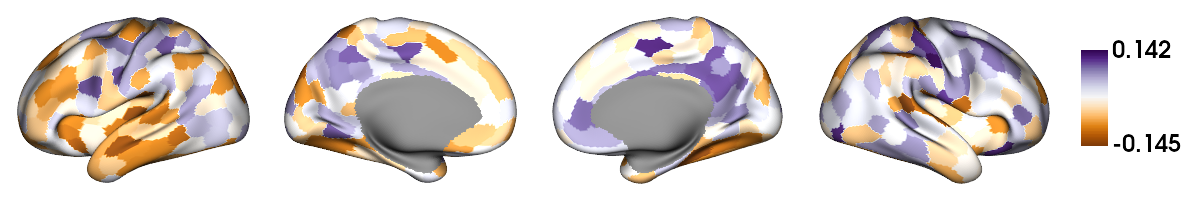

In [ ]:
# Create brain map
brain_map3 = np.full_like(atlas, np.nan, dtype=float)
for j in range(len(X3_saliences)):
    brain_map3[atlas == j+1] = X3_saliences[j]
brain_map3[atlas == 0] = np.nan

fp.plot_surface(
    data=[brain_map3],
    size=(1200, 200),
    cmap='PuOr',
    display=True,
    filename='./new_figures/Gradient3_LC1_map.png'
)


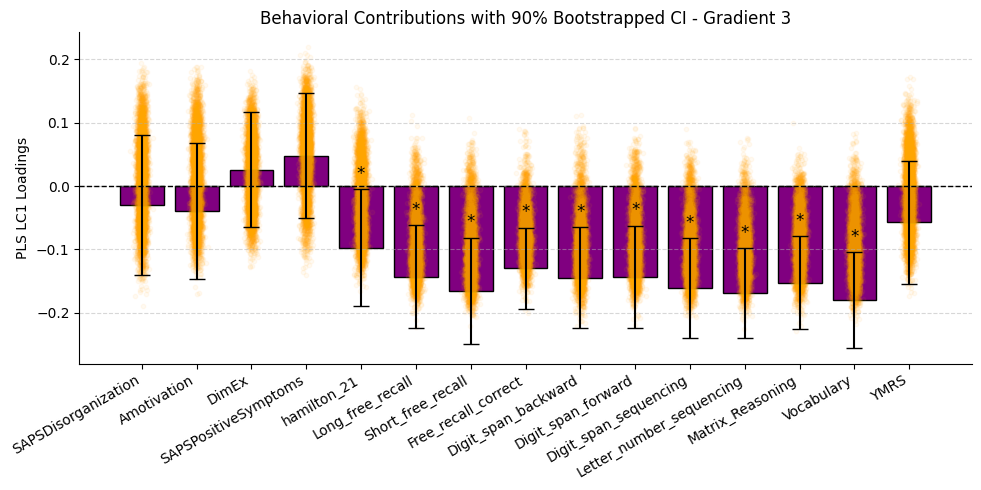

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import norm

# Bootstrapping behavioral loadings
n_boot = 5000
np.random.seed(43)
n_behav3 = Y3_std.shape[1]
boot_y3_saliences = np.zeros((n_boot, n_behav3))

for b in range(n_boot):
    idx = np.random.choice(len(X3_std), size=len(X3_std), replace=True)
    Xb = X3_std[idx]
    Yb = Y3_std[idx]

    plsb = PLSRegression(n_components=1)
    plsb.fit(Xb, Yb)
    yb = plsb.y_loadings_[:, 0]

    if np.dot(yb, Y3_saliences) < 0:
        yb *= -1

    boot_y3_saliences[b, :] = yb

# Mean, SD, CI, p-values
y_mean = Y3_saliences
y_sd = boot_y3_saliences.std(axis=0)
lower_ci = y_mean - 1.645 * y_sd
upper_ci = y_mean + 1.645 * y_sd
p_values = 2 * (1 - norm.cdf(np.abs(y_mean / y_sd)))

# Simple linear colormap from min → max
cmap = plt.get_cmap('PiYG')
colors = [cmap((val - y_mean.min()) / (y_mean.max() - y_mean.min())) for val in y_mean]

# Plot
fig, ax = plt.subplots(figsize=(10,5))
bars = ax.bar(range(n_behav3), y_mean,
              yerr=[y_mean - lower_ci, upper_ci - y_mean],
              capsize=6, color='purple', alpha=1, edgecolor='black')

# Overlay faint bootstrap points
for i in range(n_behav3):
    y = boot_y3_saliences[:, i]
    x = np.random.normal(i, 0.05, size=len(y))
    ax.scatter(x, y, color='orange', alpha=0.05, s=10)

# Horizontal line at zero
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Significance stars (CI not crossing zero)
for i in range(n_behav3):
    if lower_ci[i] > 0 or upper_ci[i] < 0:
        ax.text(i, upper_ci[i] + 0.01, "*", ha='center', va='bottom', fontsize=12)

# Labels and aesthetics
ax.set_xticks(range(n_behav3))
ax.set_xticklabels(clinical_vars3, rotation=30, ha='right')
ax.set_ylabel('PLS LC1 Loadings')
ax.set_title('Behavioral Contributions with 90% Bootstrapped CI - Gradient 3')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
plt.savefig('./new_figures/g3_loadings.png', dpi=300)
plt.tight_layout()
plt.show()



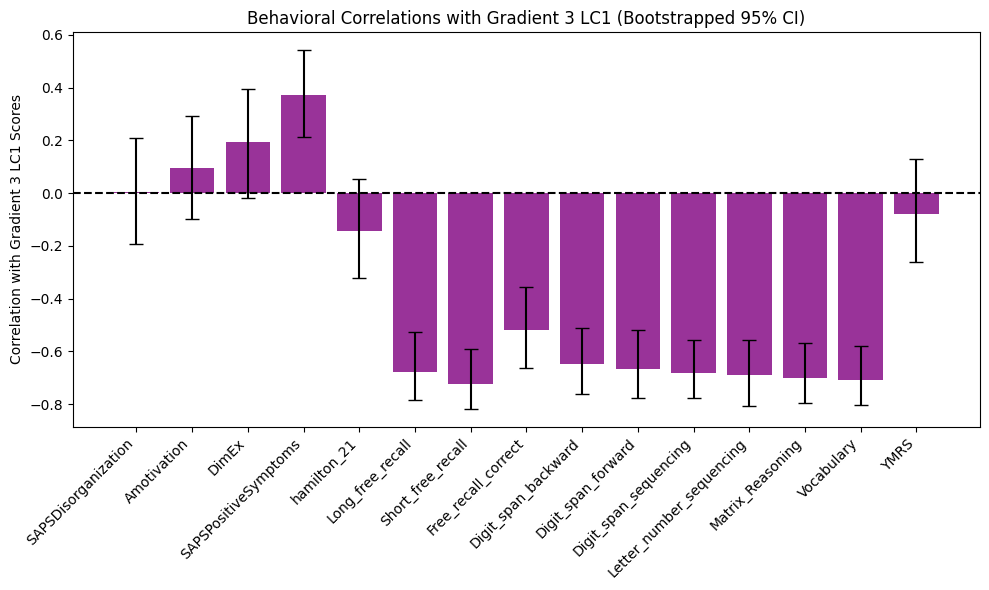

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Original correlations
behav_corrs3 = np.array([pearsonr(Y3_std[:, i], Y3_scores)[0] for i in range(Y3_std.shape[1])])

# Bootstrap correlations
boot_corrs3 = np.zeros((n_boot, len(clinical_vars3)))
for b in range(n_boot):
    idx = np.random.choice(len(Y3_std), size=len(Y3_std), replace=True)
    Yb = Y3_std[idx, :]
    scores_b = Y3_scores[idx]
    boot_corrs3[b, :] = [pearsonr(Yb[:, i], scores_b)[0] for i in range(Y3_std.shape[1])]

# Compute 95% confidence intervals
lower_ci = np.percentile(boot_corrs3, 3.5, axis=0)
upper_ci = np.percentile(boot_corrs3, 97.5, axis=0)

# Error bars = distance from mean to CI
yerr_lower = behav_corrs3 - lower_ci
yerr_upper = upper_ci - behav_corrs3
yerr = np.vstack((yerr_lower, yerr_upper))

# Coloring based on worse outcomes
worse_if_higher = ['SAPS disorganization', 'Amotivation', 'DimEx',
                   'SAPS Positive Symptoms', 'hamilton_31']

# Plot
plt.figure(figsize=(10,6))
plt.bar(clinical_vars3, behav_corrs3, yerr=yerr, capsize=5, color='purple', alpha=0.8)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with Gradient 3 LC1 Scores')
plt.title('Behavioral Correlations with Gradient 3 LC1 (Bootstrapped 95% CI)')
plt.savefig('./new_figures/g3_correlations.png', dpi=300)
plt.tight_layout()
plt.show()



# G1 subcortical embedding

In [ ]:
# Load aligned Gradient 1 (subcortical)
sub1_df = pd.read_csv('./g1_subcortical_cog.csv')

# Select only patients (diagnosis 2 or 3)
sub1_patients = sub1_df[sub1_df['diagnosis'].isin([2, 3])].copy()

# Extract subcortical embedding values
sub1_cols = [
    'sub_Accumbens_L', 'sub_Accumbens_R',
    'sub_Amygdala_L', 'sub_Amygdala_R',
    'sub_Caudate_L', 'sub_Caudate_R',
    'sub_Hippocampus_L', 'sub_Hippocampus_R',
    'sub_Pallidum_L', 'sub_Pallidum_R',
    'sub_Putamen_L', 'sub_Putamen_R',
    'sub_Thalamus_L', 'sub_Thalamus_R'
]
Xsub1 = sub1_patients[sub1_cols].values

# Behavioral/clinical measures
clinical_vars_sub1 = [
    'SAPSDisorganization', 'Amotivation', 'DimEx',
    'SAPSPositiveSymptoms', 'hamilton_21', 'Long_free_recall',
    'Short_free_recall', 'Free_recall_correct', 'Digit_span_backward',
    'Digit_span_forward', 'Digit_span_sequencing', 'Letter_number_sequencing',
    'Matrix_Reasoning', 'Vocabulary', 'YMRS'
]
Ysub1 = sub1_patients[clinical_vars_sub1].values

# Remove patients with NaNs
valid_sub1 = ~np.isnan(Ysub1).any(axis=1)
Xsub1_valid = Xsub1[valid_sub1]
Ysub1_valid = Ysub1[valid_sub1]

print(f"Xsub1_valid shape: {Xsub1_valid.shape}, Ysub1_valid shape: {Ysub1_valid.shape}")

# Standardize
Xsub1_std = StandardScaler().fit_transform(Xsub1_valid)
Ysub1_std = StandardScaler().fit_transform(Ysub1_valid)

# Fit PLS
pls_sub1 = PLSRegression(n_components=1)
pls_sub1.fit(Xsub1_std, Ysub1_std)

# Saliences (loadings)
Xsub1_saliences = pls_sub1.x_loadings_[:, 0]
Ysub1_saliences = pls_sub1.y_loadings_[:, 0]

# Individual composite scores
Xsub1_scores = pls_sub1.x_scores_[:, 0]
Ysub1_scores = pls_sub1.y_scores_[:, 0]

# Behavioral correlations with LC1
behav_corrs_sub1 = [pearsonr(Ysub1_std[:, i], Ysub1_scores)[0] for i in range(Ysub1_std.shape[1])]
print("Behavioral correlations with Subcortical Gradient 1 LC1:")
for b, c in zip(clinical_vars_sub1, behav_corrs_sub1):
    print(f"{b}: {c:.3f}")


Xsub1_valid shape: (73, 14), Ysub1_valid shape: (73, 15)
Behavioral correlations with Subcortical Gradient 1 LC1:
SAPSDisorganization: 0.268
Amotivation: 0.283
DimEx: 0.254
SAPSPositiveSymptoms: 0.525
hamilton_21: 0.036
Long_free_recall: -0.679
Short_free_recall: -0.736
Free_recall_correct: -0.524
Digit_span_backward: -0.596
Digit_span_forward: -0.650
Digit_span_sequencing: -0.681
Letter_number_sequencing: -0.679
Matrix_Reasoning: -0.674
Vocabulary: -0.715
YMRS: 0.164


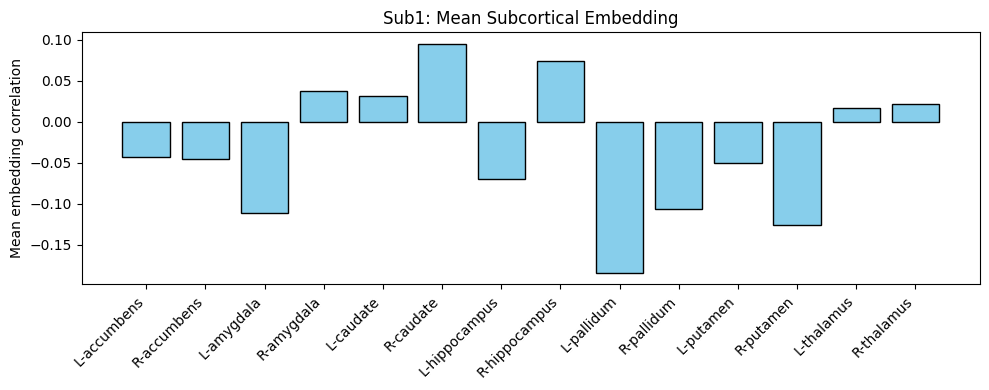

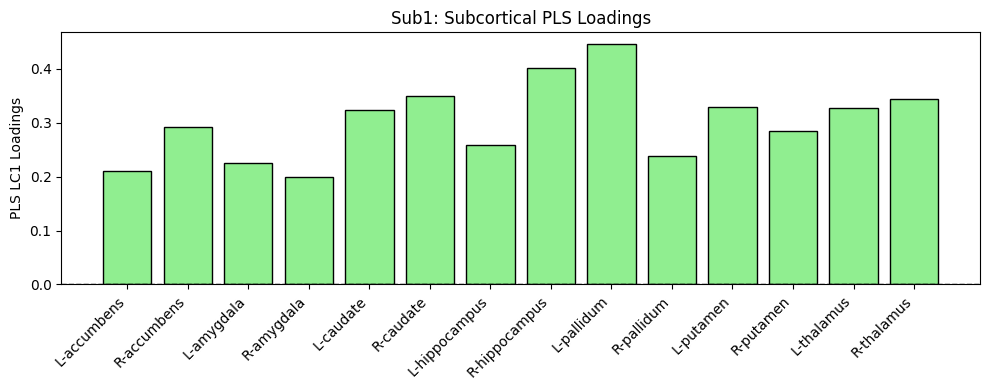

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load subcortical embeddings / PLS loadings ---
sub1_df = pd.read_csv('./g1_subcortical_embedding_corr_demo.csv')  # Sub1 embeddings

subcort_regions = [
    'sub_Accumbens_L', 'sub_Accumbens_R', 'sub_Amygdala_L', 'sub_Amygdala_R',
    'sub_Caudate_L', 'sub_Caudate_R', 'sub_Hippocampus_L', 'sub_Hippocampus_R',
    'sub_Pallidum_L', 'sub_Pallidum_R', 'sub_Putamen_L', 'sub_Putamen_R',
    'sub_Thalamus_L', 'sub_Thalamus_R'
]

subcort_labels = [
    'L-accumbens', 'R-accumbens', 'L-amygdala', 'R-amygdala',
    'L-caudate', 'R-caudate', 'L-hippocampus', 'R-hippocampus',
    'L-pallidum', 'R-pallidum', 'L-putamen', 'R-putamen',
    'L-thalamus', 'R-thalamus'
]

# --- Bar plot of mean subcortical embeddings ---
mean_embeddings = sub1_df[subcort_regions].mean(axis=0).values
plt.figure(figsize=(10,4))
plt.bar(subcort_labels, mean_embeddings, color='skyblue', edgecolor='black')
plt.ylabel('Mean embedding correlation')
plt.title('Sub1: Mean Subcortical Embedding')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./sub1_embedding_bar.png', dpi=300)
plt.show()

# --- Bar plot of subcortical PLS loadings ---
plt.figure(figsize=(10,4))
plt.bar(subcort_labels, Xsub1_saliences, color='lightgreen', edgecolor='black')
plt.ylabel('PLS LC1 Loadings')
plt.title('Sub1: Subcortical PLS Loadings')
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig('./sub1_pls_loadings_bar.png', dpi=300)
plt.show()


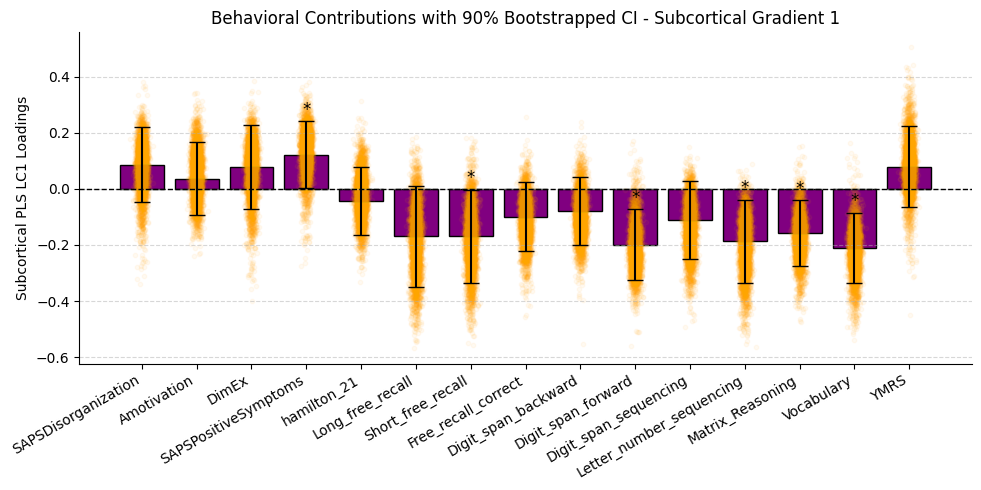

In [ ]:
# Bootstrapping behavioral loadings for Subcortical Gradient 1
n_boot = 5000
np.random.seed(43)
n_behav_sub1 = Ysub1_std.shape[1]
boot_y_sub1_saliences = np.zeros((n_boot, n_behav_sub1))

for b in range(n_boot):
    idx = np.random.choice(len(Xsub1_std), size=len(Xsub1_std), replace=True)
    Xb = Xsub1_std[idx]
    Yb = Ysub1_std[idx]

    plsb = PLSRegression(n_components=1)
    plsb.fit(Xb, Yb)
    yb = plsb.y_loadings_[:, 0]

    # Align bootstrap saliences with original direction
    if np.dot(yb, Ysub1_saliences) < 0:
        yb *= -1

    boot_y_sub1_saliences[b, :] = yb

# Mean, SD, CI, p-values
y_mean = Ysub1_saliences
y_sd = boot_y_sub1_saliences.std(axis=0)
lower_ci = y_mean - 1.645 * y_sd
upper_ci = y_mean + 1.645 * y_sd
p_values = 2 * (1 - norm.cdf(np.abs(y_mean / y_sd)))

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(
    range(n_behav_sub1),
    y_mean,
    yerr=[y_mean - lower_ci, upper_ci - y_mean],
    capsize=6,
    color='purple',
    alpha=1,
    edgecolor='black'
)

# Overlay faint bootstrap points
for i in range(n_behav_sub1):
    y = boot_y_sub1_saliences[:, i]
    x = np.random.normal(i, 0.05, size=len(y))
    ax.scatter(x, y, color='orange', alpha=0.05, s=10)

# Horizontal line at zero
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Significance stars (CI not crossing zero)
for i in range(n_behav_sub1):
    if lower_ci[i] > 0 or upper_ci[i] < 0:
        ax.text(i, upper_ci[i] + 0.01, "*", ha='center', va='bottom', fontsize=12)

# Labels
ax.set_xticks(range(n_behav_sub1))
ax.set_xticklabels(clinical_vars_sub1, rotation=30, ha='right')
ax.set_ylabel('Subcortical PLS LC1 Loadings')
ax.set_title('Behavioral Contributions with 90% Bootstrapped CI - Subcortical Gradient 1')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
plt.savefig('./new_figures/subc1_loadings.png', dpi=300)
plt.tight_layout()
plt.show()



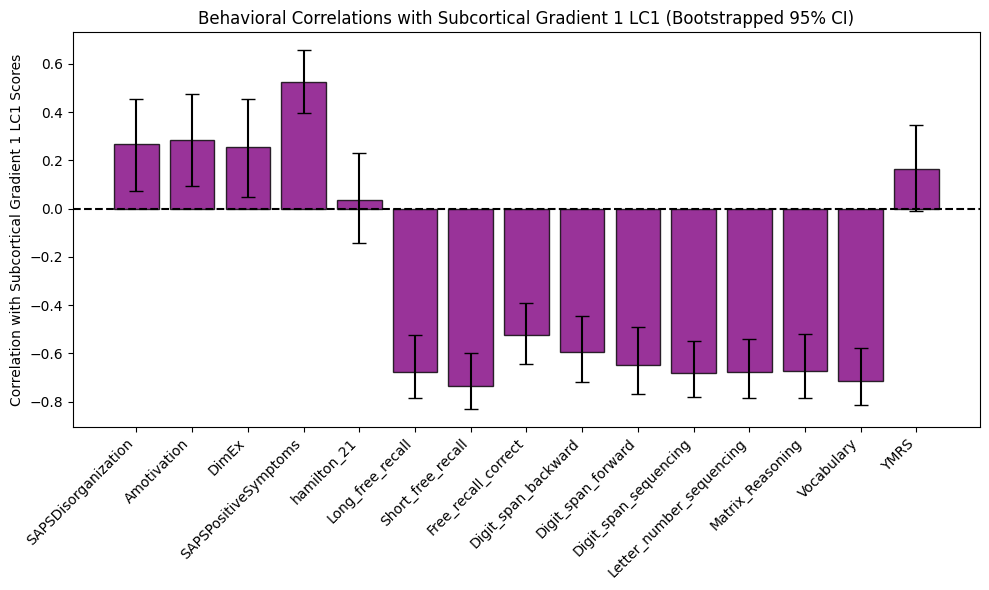

In [ ]:
# Original correlations
behav_corrs_sub1 = np.array([pearsonr(Ysub1_std[:, i], Ysub1_scores)[0] 
                             for i in range(Ysub1_std.shape[1])])

# Bootstrap correlations
boot_corrs_sub1 = np.zeros((n_boot, len(clinical_vars_sub1)))
for b in range(n_boot):
    idx = np.random.choice(len(Ysub1_std), size=len(Ysub1_std), replace=True)
    Yb = Ysub1_std[idx, :]
    scores_b = Ysub1_scores[idx]
    boot_corrs_sub1[b, :] = [pearsonr(Yb[:, i], scores_b)[0] 
                             for i in range(Ysub1_std.shape[1])]

# Compute 95% confidence intervals
lower_ci = np.percentile(boot_corrs_sub1, 3.5, axis=0)
upper_ci = np.percentile(boot_corrs_sub1, 97.5, axis=0)

# Error bars = distance from mean to CI
yerr_lower = behav_corrs_sub1 - lower_ci
yerr_upper = upper_ci - behav_corrs_sub1
yerr = np.vstack((yerr_lower, yerr_upper))

# Define variables where higher = worse outcome
worse_if_higher = ['SAPSDisorganization', 'Amotivation', 'DimEx',
                   'SAPSPositiveSymptoms', 'hamilton_21']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(clinical_vars_sub1, behav_corrs_sub1, yerr=yerr,
        capsize=5, color='purple', alpha=0.8, edgecolor='black')
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with Subcortical Gradient 1 LC1 Scores')
plt.title('Behavioral Correlations with Subcortical Gradient 1 LC1 (Bootstrapped 95% CI)')
plt.savefig('./new_figures/subc1_correlations.png', dpi=300)
plt.tight_layout()
plt.show()



# G2 subcortical embedding

In [ ]:
# Load aligned Gradient 3 (subcortical)
sub2_df = pd.read_csv('./g2_subcortical_cog.csv')

# Select only patients (diagnosis 2 or 3)
sub2_patients = sub2_df[sub2_df['diagnosis'].isin([2, 3])].copy()

# Extract subcortical embedding values
sub2_cols = [
    'sub_Accumbens_L', 'sub_Accumbens_R',
    'sub_Amygdala_L', 'sub_Amygdala_R',
    'sub_Caudate_L', 'sub_Caudate_R',
    'sub_Hippocampus_L', 'sub_Hippocampus_R',
    'sub_Pallidum_L', 'sub_Pallidum_R',
    'sub_Putamen_L', 'sub_Putamen_R',
    'sub_Thalamus_L', 'sub_Thalamus_R'
]
Xsub2 = sub2_patients[sub2_cols].values

# Behavioral/clinical measures
clinical_vars_sub2 = [
    'SAPSDisorganization', 'Amotivation', 'DimEx',
    'SAPSPositiveSymptoms', 'hamilton_21', 'Long_free_recall',
    'Short_free_recall', 'Free_recall_correct', 'Digit_span_backward',
    'Digit_span_forward', 'Digit_span_sequencing', 'Letter_number_sequencing',
    'Matrix_Reasoning', 'Vocabulary', 'YMRS'
]
Ysub2 = sub2_patients[clinical_vars_sub2].values

# Remove patients with NaNs
valid_sub2 = ~np.isnan(Ysub2).any(axis=1)
Xsub2_valid = Xsub2[valid_sub2]
Ysub2_valid = Ysub2[valid_sub2]

print(f"Xsub2_valid shape: {Xsub2_valid.shape}, Ysub2_valid shape: {Ysub2_valid.shape}")

# Standardize
Xsub2_std = StandardScaler().fit_transform(Xsub2_valid)
Ysub2_std = StandardScaler().fit_transform(Ysub2_valid)

# Fit PLS
pls_sub2 = PLSRegression(n_components=1)
pls_sub2.fit(Xsub2_std, Ysub2_std)

# Saliences (loadings)
Xsub2_saliences = pls_sub2.x_loadings_[:, 0]
Ysub2_saliences = pls_sub2.y_loadings_[:, 0]

# Individual composite scores
Xsub2_scores = pls_sub2.x_scores_[:, 0]
Ysub2_scores = pls_sub2.y_scores_[:, 0]

# Behavioral correlations with LC1
behav_corrs_sub2 = [pearsonr(Ysub2_std[:, i], Ysub2_scores)[0] for i in range(Ysub2_std.shape[1])]
print("Behavioral correlations with Subcortical Gradient 2 LC1:")
for b, c in zip(clinical_vars_sub2, behav_corrs_sub2):
    print(f"{b}: {c:.3f}")


Xsub2_valid shape: (73, 14), Ysub2_valid shape: (73, 15)
Behavioral correlations with Subcortical Gradient 2 LC1:
SAPSDisorganization: -0.334
Amotivation: -0.478
DimEx: -0.447
SAPSPositiveSymptoms: -0.695
hamilton_21: -0.229
Long_free_recall: 0.577
Short_free_recall: 0.642
Free_recall_correct: 0.519
Digit_span_backward: 0.633
Digit_span_forward: 0.564
Digit_span_sequencing: 0.688
Letter_number_sequencing: 0.569
Matrix_Reasoning: 0.649
Vocabulary: 0.578
YMRS: -0.134


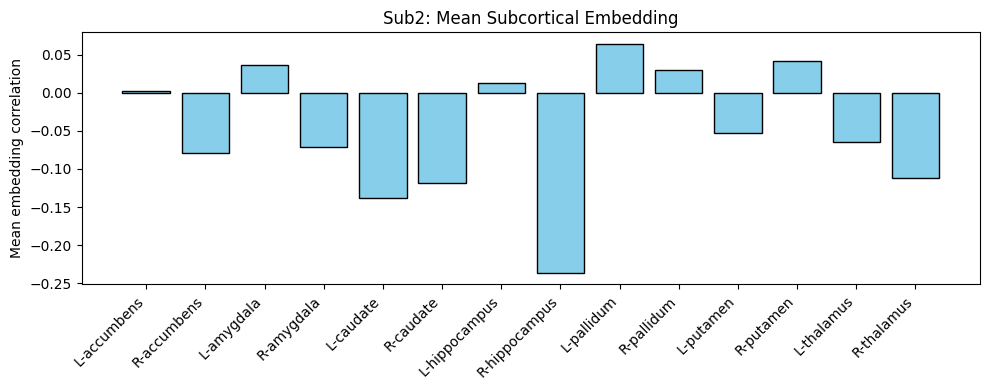

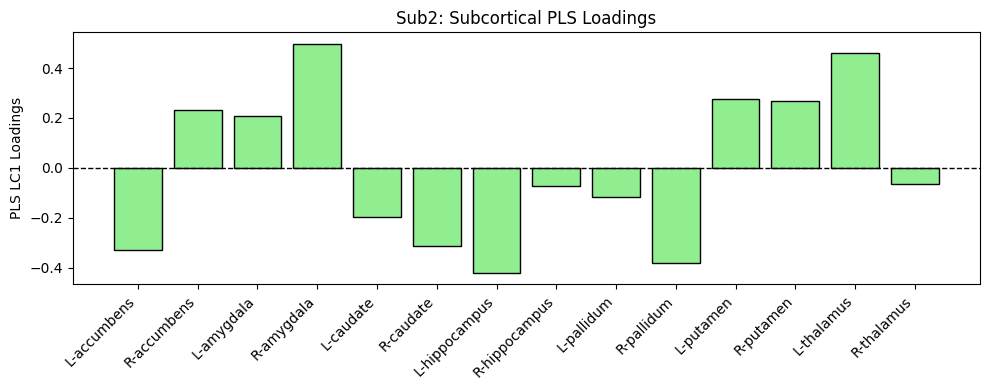

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load subcortical embeddings / PLS loadings ---
sub2_df = pd.read_csv('./g2_subcortical_embedding_corr_demo.csv')  # Sub1 embeddings

subcort_regions = [
    'sub_Accumbens_L', 'sub_Accumbens_R', 'sub_Amygdala_L', 'sub_Amygdala_R',
    'sub_Caudate_L', 'sub_Caudate_R', 'sub_Hippocampus_L', 'sub_Hippocampus_R',
    'sub_Pallidum_L', 'sub_Pallidum_R', 'sub_Putamen_L', 'sub_Putamen_R',
    'sub_Thalamus_L', 'sub_Thalamus_R'
]

subcort_labels = [
    'L-accumbens', 'R-accumbens', 'L-amygdala', 'R-amygdala',
    'L-caudate', 'R-caudate', 'L-hippocampus', 'R-hippocampus',
    'L-pallidum', 'R-pallidum', 'L-putamen', 'R-putamen',
    'L-thalamus', 'R-thalamus'
]

# --- Bar plot of mean subcortical embeddings ---
mean_embeddings = sub2_df[subcort_regions].mean(axis=0).values
plt.figure(figsize=(10,4))
plt.bar(subcort_labels, mean_embeddings, color='skyblue', edgecolor='black')
plt.ylabel('Mean embedding correlation')
plt.title('Sub2: Mean Subcortical Embedding')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./sub2_embedding_bar.png', dpi=300)
plt.show()

# --- Bar plot of subcortical PLS loadings ---
plt.figure(figsize=(10,4))
plt.bar(subcort_labels, Xsub2_saliences, color='lightgreen', edgecolor='black')
plt.ylabel('PLS LC1 Loadings')
plt.title('Sub2: Subcortical PLS Loadings')
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig('./sub2_pls_loadings_bar.png', dpi=300)
plt.show()


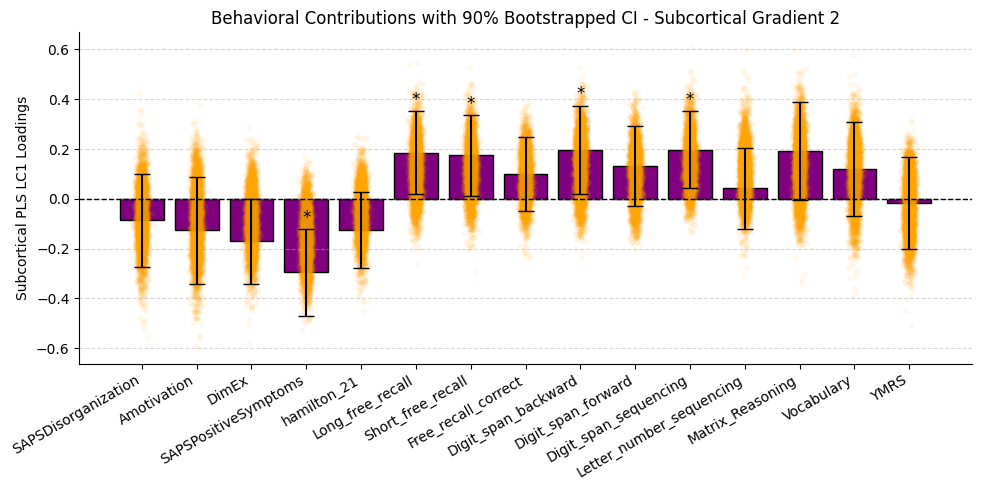

In [ ]:
# Bootstrapping behavioral loadings for Subcortical Gradient 2
n_boot = 5000
np.random.seed(43)
n_behav_sub2 = Ysub2_std.shape[1]
boot_y_sub2_saliences = np.zeros((n_boot, n_behav_sub2))

for b in range(n_boot):
    idx = np.random.choice(len(Xsub2_std), size=len(Xsub2_std), replace=True)
    Xb = Xsub2_std[idx]
    Yb = Ysub2_std[idx]

    plsb = PLSRegression(n_components=1)
    plsb.fit(Xb, Yb)
    yb = plsb.y_loadings_[:, 0]

    # Align bootstrap saliences with original direction
    if np.dot(yb, Ysub2_saliences) < 0:
        yb *= -1

    boot_y_sub2_saliences[b, :] = yb

# Mean, SD, CI, p-values
y_mean = Ysub2_saliences
y_sd = boot_y_sub2_saliences.std(axis=0)
lower_ci = y_mean - 1.645 * y_sd
upper_ci = y_mean + 1.645 * y_sd
p_values = 2 * (1 - norm.cdf(np.abs(y_mean / y_sd)))

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(
    range(n_behav_sub2),
    y_mean,
    yerr=[y_mean - lower_ci, upper_ci - y_mean],
    capsize=6,
    color='purple',
    alpha=1,
    edgecolor='black'
)

# Overlay faint bootstrap points
for i in range(n_behav_sub2):
    y = boot_y_sub2_saliences[:, i]
    x = np.random.normal(i, 0.05, size=len(y))
    ax.scatter(x, y, color='orange', alpha=0.05, s=10)

# Horizontal line at zero
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Significance stars (CI not crossing zero)
for i in range(n_behav_sub2):
    if lower_ci[i] > 0 or upper_ci[i] < 0:
        ax.text(i, upper_ci[i] + 0.01, "*", ha='center', va='bottom', fontsize=12)

# Labels
ax.set_xticks(range(n_behav_sub2))
ax.set_xticklabels(clinical_vars_sub2, rotation=30, ha='right')
ax.set_ylabel('Subcortical PLS LC1 Loadings')
ax.set_title('Behavioral Contributions with 90% Bootstrapped CI - Subcortical Gradient 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
plt.savefig('./new_figures/subc2_loadings.png', dpi=300)
plt.tight_layout()
plt.show()



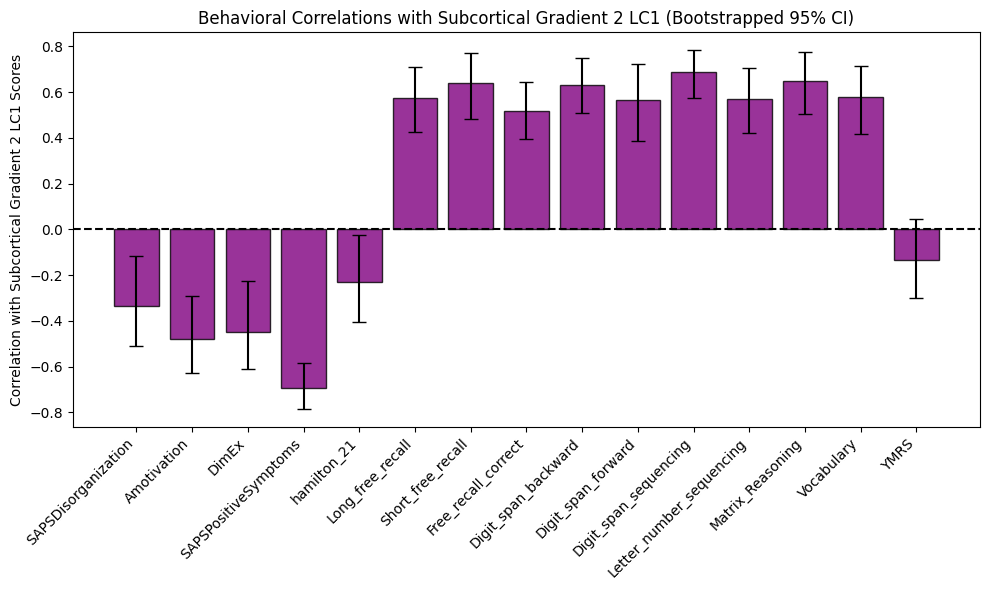

In [ ]:
# Original correlations
behav_corrs_sub2 = np.array([pearsonr(Ysub2_std[:, i], Ysub2_scores)[0] 
                             for i in range(Ysub2_std.shape[1])])

# Bootstrap correlations
boot_corrs_sub2 = np.zeros((n_boot, len(clinical_vars_sub2)))
for b in range(n_boot):
    idx = np.random.choice(len(Ysub2_std), size=len(Ysub2_std), replace=True)
    Yb = Ysub2_std[idx, :]
    scores_b = Ysub2_scores[idx]
    boot_corrs_sub2[b, :] = [pearsonr(Yb[:, i], scores_b)[0] 
                             for i in range(Ysub2_std.shape[1])]

# Compute 95% confidence intervals
lower_ci = np.percentile(boot_corrs_sub2, 3.5, axis=0)
upper_ci = np.percentile(boot_corrs_sub2, 97.5, axis=0)

# Error bars = distance from mean to CI
yerr_lower = behav_corrs_sub2 - lower_ci
yerr_upper = upper_ci - behav_corrs_sub2
yerr = np.vstack((yerr_lower, yerr_upper))

# Define variables where higher = worse outcome
worse_if_higher = ['SAPSDisorganization', 'Amotivation', 'DimEx',
                   'SAPSPositiveSymptoms', 'hamilton_21']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(clinical_vars_sub2, behav_corrs_sub2, yerr=yerr,
        capsize=5, color='purple', alpha=0.8, edgecolor='black')
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with Subcortical Gradient 2 LC1 Scores')
plt.title('Behavioral Correlations with Subcortical Gradient 2 LC1 (Bootstrapped 95% CI)')
plt.savefig('./new_figures/subc2_correlations.png', dpi=300)
plt.tight_layout()
plt.show()



# G3 subcortical embedding

In [ ]:
# Load aligned Gradient 3 (subcortical)
sub3_df = pd.read_csv('./g3_subcortical_cog.csv')

# Select only patients (diagnosis 2 or 3)
sub3_patients = sub3_df[sub3_df['diagnosis'].isin([2, 3])].copy()

# Extract subcortical embedding values
sub3_cols = [
    'sub_Accumbens_L', 'sub_Accumbens_R',
    'sub_Amygdala_L', 'sub_Amygdala_R',
    'sub_Caudate_L', 'sub_Caudate_R',
    'sub_Hippocampus_L', 'sub_Hippocampus_R',
    'sub_Pallidum_L', 'sub_Pallidum_R',
    'sub_Putamen_L', 'sub_Putamen_R',
    'sub_Thalamus_L', 'sub_Thalamus_R'
]
Xsub3 = sub3_patients[sub3_cols].values


# Behavioral/clinical measures
clinical_vars_sub3 = [
    'SAPSDisorganization', 'Amotivation', 'DimEx',
    'SAPSPositiveSymptoms', 'hamilton_21', 'Long_free_recall',
    'Short_free_recall', 'Free_recall_correct', 'Digit_span_backward',
    'Digit_span_forward', 'Digit_span_sequencing', 'Letter_number_sequencing',
    'Matrix_Reasoning', 'Vocabulary', 'YMRS'
]
Ysub3 = sub3_patients[clinical_vars_sub3].values

# Remove patients with NaNs
valid_sub3 = ~np.isnan(Ysub3).any(axis=1)
Xsub3_valid = Xsub3[valid_sub3]
Ysub3_valid = Ysub3[valid_sub3]

print(f"Xsub3_valid shape: {Xsub3_valid.shape}, Ysub3_valid shape: {Ysub3_valid.shape}")

# Standardize
Xsub3_std = StandardScaler().fit_transform(Xsub3_valid)
Ysub3_std = StandardScaler().fit_transform(Ysub3_valid)

# Fit PLS
pls_sub3 = PLSRegression(n_components=1)
pls_sub3.fit(Xsub3_std, Ysub3_std)

# Saliences (loadings)
Xsub3_saliences = pls_sub3.x_loadings_[:, 0]
Ysub3_saliences = pls_sub3.y_loadings_[:, 0]

# Individual composite scores
Xsub3_scores = pls_sub3.x_scores_[:, 0]
Ysub3_scores = pls_sub3.y_scores_[:, 0]

# Behavioral correlations with LC1
behav_corrs_sub3 = [pearsonr(Ysub3_std[:, i], Ysub3_scores)[0] for i in range(Ysub3_std.shape[1])]
print("Behavioral correlations with Subcortical Gradient 3 LC1:")
for b, c in zip(clinical_vars_sub3, behav_corrs_sub3):
    print(f"{b}: {c:.3f}")


Xsub3_valid shape: (73, 14), Ysub3_valid shape: (73, 15)
Behavioral correlations with Subcortical Gradient 3 LC1:
SAPSDisorganization: -0.169
Amotivation: -0.319
DimEx: -0.438
SAPSPositiveSymptoms: -0.589
hamilton_21: -0.035
Long_free_recall: 0.560
Short_free_recall: 0.598
Free_recall_correct: 0.673
Digit_span_backward: 0.694
Digit_span_forward: 0.631
Digit_span_sequencing: 0.642
Letter_number_sequencing: 0.589
Matrix_Reasoning: 0.696
Vocabulary: 0.575
YMRS: 0.037


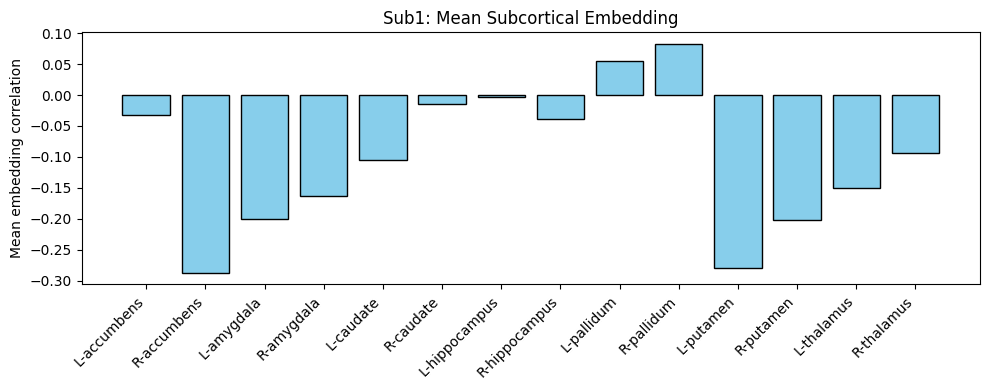

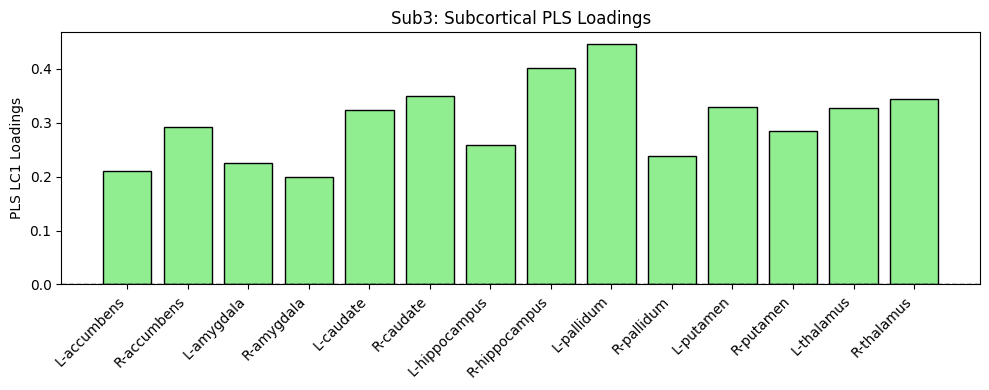

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load subcortical embeddings / PLS loadings ---
sub3_df = pd.read_csv('./g3_subcortical_embedding_corr_demo.csv')  # Sub1 embeddings

subcort_regions = [
    'sub_Accumbens_L', 'sub_Accumbens_R', 'sub_Amygdala_L', 'sub_Amygdala_R',
    'sub_Caudate_L', 'sub_Caudate_R', 'sub_Hippocampus_L', 'sub_Hippocampus_R',
    'sub_Pallidum_L', 'sub_Pallidum_R', 'sub_Putamen_L', 'sub_Putamen_R',
    'sub_Thalamus_L', 'sub_Thalamus_R'
]

subcort_labels = [
    'L-accumbens', 'R-accumbens', 'L-amygdala', 'R-amygdala',
    'L-caudate', 'R-caudate', 'L-hippocampus', 'R-hippocampus',
    'L-pallidum', 'R-pallidum', 'L-putamen', 'R-putamen',
    'L-thalamus', 'R-thalamus'
]

# --- Bar plot of mean subcortical embeddings ---
mean_embeddings = sub3_df[subcort_regions].mean(axis=0).values
plt.figure(figsize=(10,4))
plt.bar(subcort_labels, mean_embeddings, color='skyblue', edgecolor='black')
plt.ylabel('Mean embedding correlation')
plt.title('Sub1: Mean Subcortical Embedding')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./sub3_embedding_bar.png', dpi=300)
plt.show()

# --- Bar plot of subcortical PLS loadings ---
plt.figure(figsize=(10,4))
plt.bar(subcort_labels, Xsub1_saliences, color='lightgreen', edgecolor='black')
plt.ylabel('PLS LC1 Loadings')
plt.title('Sub3: Subcortical PLS Loadings')
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig('./sub3_pls_loadings_bar.png', dpi=300)
plt.show()


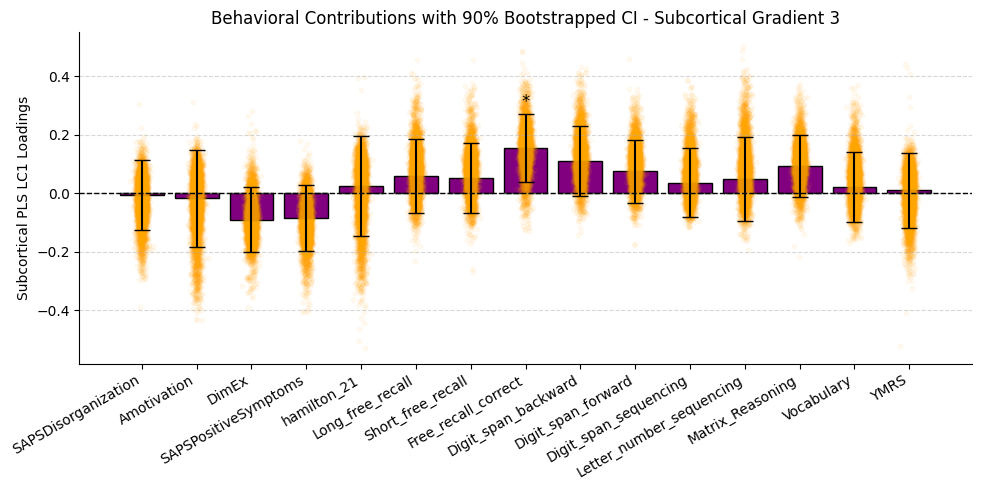

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import norm

# Bootstrapping behavioral loadings for Subcortical Gradient 3
n_boot = 5000
np.random.seed(43)
n_behav_sub3 = Ysub3_std.shape[1]
boot_y_sub3_saliences = np.zeros((n_boot, n_behav_sub3))

for b in range(n_boot):
    idx = np.random.choice(len(Xsub3_std), size=len(Xsub3_std), replace=True)
    Xb = Xsub3_std[idx]
    Yb = Ysub3_std[idx]

    plsb = PLSRegression(n_components=1)
    plsb.fit(Xb, Yb)
    yb = plsb.y_loadings_[:, 0]

    # Align bootstrap saliences with original direction
    if np.dot(yb, Ysub3_saliences) < 0:
        yb *= -1

    boot_y_sub3_saliences[b, :] = yb

# Mean, SD, CI, p-values
y_mean = Ysub3_saliences
y_sd = boot_y_sub3_saliences.std(axis=0)
lower_ci = y_mean - 1.645 * y_sd
upper_ci = y_mean + 1.645 * y_sd
p_values = 2 * (1 - norm.cdf(np.abs(y_mean / y_sd)))

# Simple linear colormap from min → max
cmap = plt.get_cmap('PiYG')
colors = [cmap((val - y_mean.min()) / (y_mean.max() - y_mean.min())) for val in y_mean]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(
    range(n_behav_sub3),
    y_mean,
    yerr=[y_mean - lower_ci, upper_ci - y_mean],
    capsize=6,
    color='purple',
    alpha=1,
    edgecolor='black'
)

# Overlay faint bootstrap points
for i in range(n_behav_sub3):
    y = boot_y_sub3_saliences[:, i]
    x = np.random.normal(i, 0.05, size=len(y))
    ax.scatter(x, y, color='orange', alpha=0.05, s=10)

# Horizontal line at zero
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Significance stars (CI not crossing zero)
for i in range(n_behav_sub3):
    if lower_ci[i] > 0 or upper_ci[i] < 0:
        ax.text(i, upper_ci[i] + 0.01, "*", ha='center', va='bottom', fontsize=12)

# Labels and aesthetics
ax.set_xticks(range(n_behav_sub3))
ax.set_xticklabels(clinical_vars_sub3, rotation=30, ha='right')
ax.set_ylabel('Subcortical PLS LC1 Loadings')
ax.set_title('Behavioral Contributions with 90% Bootstrapped CI - Subcortical Gradient 3')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
plt.savefig('./new_figures/subc3_loadings.png', dpi=300)
plt.tight_layout()
plt.show()



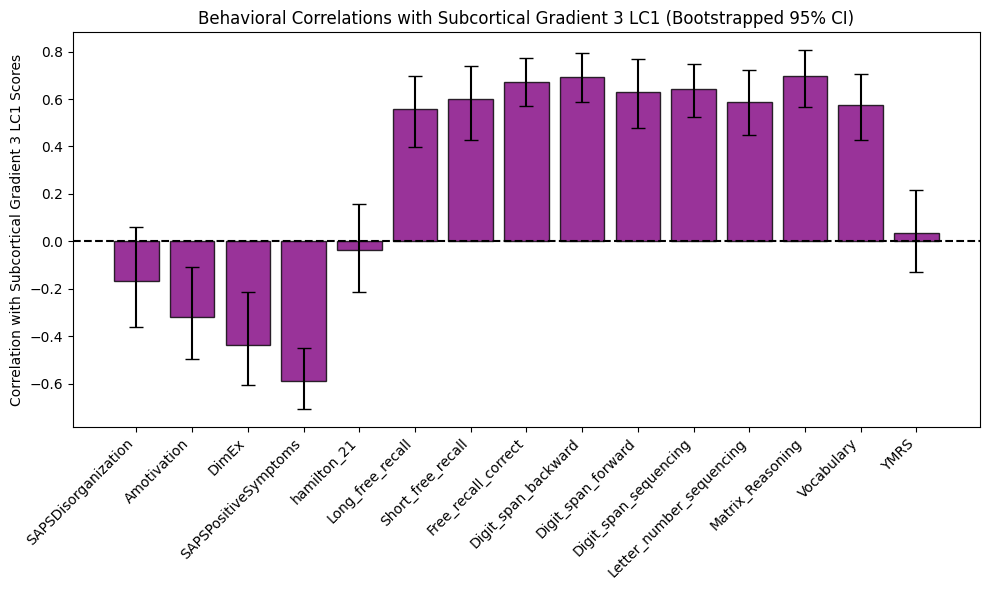

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Original correlations
behav_corrs_sub3 = np.array([pearsonr(Ysub3_std[:, i], Ysub3_scores)[0] 
                             for i in range(Ysub3_std.shape[1])])

# Bootstrap correlations
boot_corrs_sub3 = np.zeros((n_boot, len(clinical_vars_sub3)))
for b in range(n_boot):
    idx = np.random.choice(len(Ysub3_std), size=len(Ysub3_std), replace=True)
    Yb = Ysub3_std[idx, :]
    scores_b = Ysub3_scores[idx]
    boot_corrs_sub3[b, :] = [pearsonr(Yb[:, i], scores_b)[0] 
                             for i in range(Ysub3_std.shape[1])]

# Compute 95% confidence intervals
lower_ci = np.percentile(boot_corrs_sub3, 3.5, axis=0)
upper_ci = np.percentile(boot_corrs_sub3, 97.5, axis=0)

# Error bars = distance from mean to CI
yerr_lower = behav_corrs_sub3 - lower_ci
yerr_upper = upper_ci - behav_corrs_sub3
yerr = np.vstack((yerr_lower, yerr_upper))

# Define variables where higher = worse outcome
worse_if_higher = ['SAPSDisorganization', 'Amotivation', 'DimEx',
                   'SAPSPositiveSymptoms', 'hamilton_21']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(clinical_vars_sub3, behav_corrs_sub3, yerr=yerr, capsize=5,
        color='purple', alpha=0.8, edgecolor='black')
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with Subcortical Gradient 3 LC1 Scores')
plt.title('Behavioral Correlations with Subcortical Gradient 3 LC1 (Bootstrapped 95% CI)')
plt.savefig('./new_figures/subc3_correlations.png', dpi=300)
plt.tight_layout()
plt.show()



In [ ]:
plot_subcortical

NameError: name 'plot_subcortical' is not defined

In [ ]:
import numpy as np
import pandas as pd
from enigmatoolbox.plotting.surface_plotting import plot_subcortical

# Load your CSV
demo_subcort = pd.read_csv('./g1_subcortical_embedding_corr_demo.csv')

# Extract means in the EXACT order ENIGMA expects (14 values, no ventricles)
subcort_order = [
    'sub_Accumbens_L', 'sub_Amygdala_L', 'sub_Caudate_L', 'sub_Hippocampus_L',
    'sub_Pallidum_L', 'sub_Putamen_L', 'sub_Thalamus_L',
    'sub_Accumbens_R', 'sub_Amygdala_R', 'sub_Caudate_R', 'sub_Hippocampus_R',
    'sub_Pallidum_R', 'sub_Putamen_R', 'sub_Thalamus_R'
]

mean_embeddings = demo_subcort[subcort_order].mean(axis=0).to_numpy()

# Define color range
Q1, Q3 = np.nanmin(mean_embeddings), np.nanmax(mean_embeddings)

# Display as a labeled table
subcort_vector = pd.Series(mean_embeddings, index=subcort_order, name="Mean Embedding")
print(subcort_vector)

# Plot
plot_subcortical(
    array_name=mean_embeddings,
    ventricles=False,   # IMPORTANT: matches 14-value input
    size=(1600, 800),
    cmap="PuOr",
    color_bar=True,
    color_range=(Q1, Q3),
    screenshot=True,
    filename="./new_figures/g1_subcortical_embedding.png",
    transparent_bg=True
)


sub_Accumbens_L     -0.042719
sub_Amygdala_L      -0.111790
sub_Caudate_L        0.031361
sub_Hippocampus_L   -0.070173
sub_Pallidum_L      -0.184451
sub_Putamen_L       -0.050094
sub_Thalamus_L       0.016169
sub_Accumbens_R     -0.045784
sub_Amygdala_R       0.037697
sub_Caudate_R        0.095026
sub_Hippocampus_R    0.073562
sub_Pallidum_R      -0.106982
sub_Putamen_R       -0.126046
sub_Thalamus_R       0.021219
Name: Mean Embedding, dtype: float64


TypeError: SetCells argument 2: method requires a VTK object

c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\enigmatoolbox\datasets\base.py:378: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if parcellation is 'aparc':
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\enigmatoolbox\datasets\base.py:378: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if parcellation is 'aparc':
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\enigmatoolbox\datasets\base.py:378: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if parcellation is 'aparc':


AttributeError: type object 'PointSet' has no attribute '__vtkname__'

In [ ]:
plot_subcortical(
     27     array_name=mean_embeddings,
     28     ventricles=False,   # IMPORTANT: matches 14-value input
     29     size=(1600, 800),
     30     cmap="PuOr",
     31     color_bar=True,
     32     color_range=(Q1, Q3),
     33     screenshot=True,
     34     filename="./new_figures/g1_subcortical_embedding.png",
     35     transparent_bg=True
     36 )

In [ ]:
!pip freeze


anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
async-lru==2.0.5
attrs==25.3.0
autocommand==2.2.2
babel==2.17.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.3
bleach==6.2.0
brainsmash==0.11.0
brainspace==0.1.20
certifi==2025.1.31
cffi==1.17.1
charset-normalizer==3.4.1
colorama==0.4.6
comm==0.2.2
contourpy==1.3.2
cycler==0.12.1
debugpy==1.8.13
decorator==5.2.1
defusedxml==0.7.1
enigmatoolbox==2.0.3
et_xmlfile @ file:///home/conda/feedstock_root/build_artifacts/et_xmlfile_1733749653422/work
exceptiongroup==1.2.2
executing==2.2.0
fastjsonschema==2.21.1
fonttools==4.60.0
fqdn==1.5.1
h11==0.14.0
httpcore==1.0.7
httpx==0.28.1
idna==3.10
importlib_metadata==8.0.0
importlib_resources==6.5.2
inflect==7.3.1
ipykernel==6.29.5
ipython==8.35.0
isoduration==20.11.0
jaraco.collections==5.1.0
jaraco.context==5.3.0
jaraco.functools==4.0.1
jaraco.text==3.12.1
jedi==0.19.2
Jinja2==3.1.6
joblib==1.4.2
json5==0.12.0
jsonpointer==3.0.0
jsonschema==4.23.0
jsonsche